In [1]:
import numpy as np
import pandas as pd
import imp
import os
import sys
import tensorflow as tf
import random
import pickle
from numba import njit
from functools import lru_cache
from IPython.display import Audio, display
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

tf.random.set_seed(3)
random.seed(3)

# notes
* give it a 3 layer?
* have larger lstm output
* put more batchnorm layers
* have it predict the next stop - use an embedding (mse?) or a one hot encoded (cat cross entropy?)
* get a more clever way to assign embedding dimensionalty
* feed it in any route of stops - keep the direciton as an input

I could ask it for what we actually want...
* ask it for how late it will be to a specific stop
* give it the stop I'd that I'm asking for, how far out it is somehow, and then a chunk of bus data from an arbitrary number of stops back.

What the transit agency wants?
* hit up Miles to see what the cannonical stop sequence is for each direction - or just assume that the most common trip is cannonical (use old code)
* For each trip, (CHECK IF CANNONICAL TRIP HAS DUPLICATES) remove duplicates, stick them into their places in the cannonical stop sequence
* a 2 - 3 layer lstm, each returns sequences
* right pad input (zeroes on left) to simulate predicting an incomplete trip.
* have each stop take in everything, return deviances - mse 

In [2]:
url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(
        Audio(
            url=url_done,
            autoplay=True,
        )
    )

In [3]:
data_dir = os.path.join(os.getcwd(), "..", "data")

In [4]:
# direction = 0

In [5]:
def df_pop(df, labels):
    popped = df[labels]
    df = df.drop(columns=labels)
    return df, popped


trips, dates, labels = None, None, None
lstm_dir = os.path.join(data_dir, "trips_for_lstm")
files = [f + ".npy" for f in ["non_categories", "categories", "labels", "cardinality"]]
in_length = 20
out_length = 10
num_samples = 3
recompute = True

if recompute:

    pickle_path = os.path.join(data_dir, "mega_pickle")
    df = pd.read_pickle(pickle_path)
    df = df.head(1000000)

    df = df.drop(columns=["route_number", "time_cat_stop_time", "time_cat_leave_time"])

    df = df.sort_values(["service_date", "train", "trip_number", "stop_time"])
    df = df.reset_index(drop=True)

    dtypes = df.dtypes

    categories_names = dtypes[dtypes == "category"]
    categories_names = categories_names.index.to_list()

    non_categories_names = dtypes[dtypes != "category"]
    non_categories_names = non_categories_names.index.to_list()
    non_categories_names.remove("service_date")
    non_categories_names.remove("arrival_deviance")
    label_name = ["arrival_deviance", "location_id"]

    enc = OrdinalEncoder()
    df[categories_names] = enc.fit_transform(df[categories_names])

    cardinality = []
    card_dict = {}
    for category in categories_names:
        num = len(df[category].unique())
        cardinality.append(num)
        card_dict[category] = num

    df[non_categories_names] = (
        df[non_categories_names] - df[non_categories_names].mean()
    ) / df[non_categories_names].std()

    trips = df.groupby(["service_date", "train", "trip_number"])
    trips = [trip for _, trip in trips]

    random.shuffle(
        trips
    )  # WE CAN DO THIS BECAUSE WE'RE ONLY TRYING TO PREDICT THE NEXT TRIP

    x1 = []
    x2 = []
    y = []
    for trip in trips:
        if trip.shape[0] > 60:
            label = trip[label_name].to_numpy(dtype=np.float32)
            category = trip[categories_names].to_numpy(dtype=np.int32)
            non_category = trip[non_categories_names].to_numpy(dtype=np.float32)

            num_stops = trip.shape[0]
            random_list = random.sample(
                range(in_length, num_stops - out_length), num_samples
            )
            for i in random_list:
                non_cat = non_category[i - in_length : i]
                cat = category[i - in_length : i]
                lab = label[i : i + out_length]
                x1.append(non_cat)
                x2.append(cat)
                y.append(lab)

    non_categories = np.stack(x1)
    categories = np.stack(x2)
    labels = np.stack(y)

    with open("card_dict.pickle", "wb") as handle:
        pickle.dump(card_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    arrays = [non_categories, categories, labels, cardinality]

    for file_name, array in zip(files, arrays):
        file_path = os.path.join(lstm_dir, file_name)
        np.save(file_path, array)

else:
    arrays = []
    for file_name in files:
        file_path = os.path.join(lstm_dir, file_name)
        arrays.append(np.load(file_path))
    non_categories, categories, labels, cardinality = arrays

    with open("card_dict.pickle", "rb") as handle:
        card_dict = pickle.load(handle)

print(
    non_categories.shape,
    categories.shape,
    labels.shape,
)

datalen = non_categories.shape[0]
non_category_width = non_categories.shape[2]
category_width = categories.shape[2]

print(datalen, non_category_width, category_width)

(28641, 20, 17) (28641, 20, 10) (28641, 10, 2)
28641 17 10


In [6]:
num_stops = card_dict["location_id"]

non_categories_shape = (in_length, non_category_width)
categories_shape = (in_length, category_width)
deviance_shape = (out_length,)
stop_shape = (out_length, num_stops)


def one_hot(hot):
    a = np.zeros((out_length, num_stops))
    a[list(range(out_length)), hot] = 1
    return a


def data_generator(non_categories, categories, labels):
    for non_category, category, label in zip(non_categories, categories, labels):
        dev = label[:, 0]
        loc = label[:, 1].astype(int)
        yield {
            "non_categories": non_category,
            "categories": category,
        }, {"deviance": dev, "location_id": one_hot(loc)}


def get_dataset(non_categories, categories, labels):
    return tf.data.Dataset.from_generator(
        data_generator,
        args=[non_categories, categories, labels],
        output_signature=(
            {
                "non_categories": tf.TensorSpec(
                    shape=non_categories_shape, dtype=tf.float32
                ),
                "categories": tf.TensorSpec(shape=categories_shape, dtype=tf.int32),
            },
            {
                "deviance": tf.TensorSpec(shape=deviance_shape, dtype=tf.float32),
                "location_id": tf.TensorSpec(shape=stop_shape, dtype=tf.float32),
            },
        ),
    )

In [7]:
batch_size = 32

train = 0.7
val = 0.2
test = 0.1
assert train + val + test == 1

train = int(train * datalen)
val = int(val * datalen)
test = int(test * datalen)

print(train, val, test)

dataset = get_dataset(non_categories, categories, labels)

train_dataset = dataset.take(train).shuffle(10000).batch(batch_size)
val_dataset = dataset.skip(train).take(val).batch(batch_size)
test_dataset = dataset.skip(train + val).batch(batch_size)

22912 2864 2864


In [8]:
# sequence to sequence and https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

drop_rate = 0.2
embed_scale = 4
LSTM_dim = 1024

non_categories_input = tf.keras.Input(shape=non_categories_shape, name="non_categories")
categories_input = tf.keras.Input(shape=categories_shape, name="categories")

non_categories = non_categories_input
categories = categories_input

cat_list = tf.unstack(categories, axis=2)
embed_out = []
for cat, card in zip(cat_list, cardinality):
    embed_out.append(tf.keras.layers.Embedding(card, card)(cat))

non_categories = tf.keras.layers.BatchNormalization()(non_categories)

encode_1 = tf.keras.layers.Concatenate(axis=2)([non_categories, *embed_out])
encode_1 = tf.keras.layers.LSTM(LSTM_dim, return_state=True, return_sequences=True)(
    encode_1
)
encoder_1_state = encode_1[1:]
encoder_1_out = encode_1[0]
# encoder_1_out = tf.keras.layers.BatchNormalization()(encoder_1_out)

encode_2 = tf.keras.layers.LSTM(LSTM_dim, return_state=True, return_sequences=False)(
    encoder_1_out
)
encoder_2_state = encode_2[1:]
encoder_2_out = encode_2[0]
encoder_2_out = tf.keras.layers.BatchNormalization()(encoder_2_out)

# encode_3 = tf.keras.layers.LSTM(LSTM_dim, return_state=True)(encoder_2_out)
# encoder_3_state = encode_3[1:]
# encoder_3_out = encode_3[0]
# encoder_3_out = tf.keras.layers.BatchNormalization()(encoder_3_out)

decoder_inputs = tf.keras.layers.RepeatVector(out_length)(encoder_2_out)

decoder_1 = tf.keras.layers.LSTM(LSTM_dim, return_sequences=True)(
    decoder_inputs, initial_state=encoder_1_state
)
# decoder_1 = tf.keras.layers.BatchNormalization()(decoder_1)

decoder_2 = tf.keras.layers.LSTM(LSTM_dim, return_sequences=True)(
    decoder_1, initial_state=encoder_2_state
)
decoder_2 = tf.keras.layers.BatchNormalization()(decoder_2)

# decoder_3 = tf.keras.layers.LSTM(LSTM_dim, return_sequences=True)(
#     decoder_2, initial_state=encoder_3_state
# )
# decoder_3= tf.keras.layers.BatchNormalization()(decoder_3)

deviance = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1), name="deviance")(
    decoder_2
)
location_id = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(num_stops), name="location_id"
)(decoder_2)

model = tf.keras.Model(
    inputs=[non_categories_input, categories],
    outputs=[deviance, location_id],
)

total parameters: 33,910,839


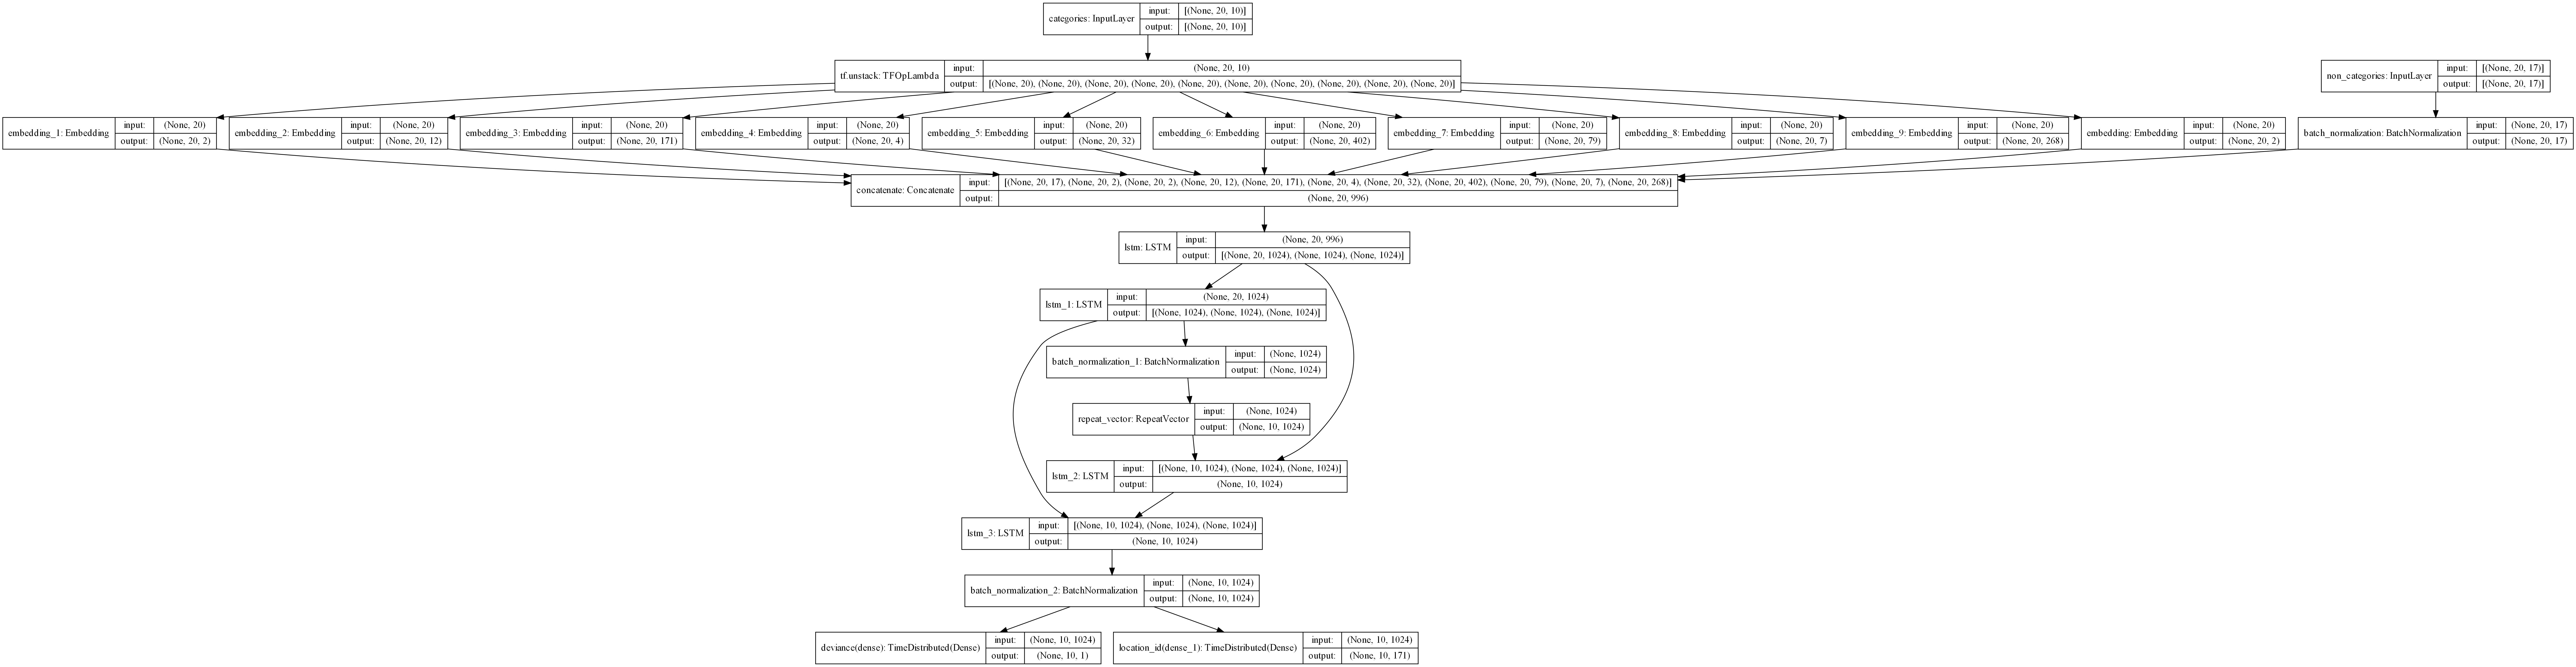

In [9]:
model.compile(
    optimizer="adam",
    loss=[
        tf.keras.losses.MeanSquaredError(reduction="auto"),
        tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    metrics=[],
)
print("total parameters: {:,}".format(model.count_params()))
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, dpi=227)

In [10]:
monitor_param = "val_loss"

nan_terminate = tf.keras.callbacks.TerminateOnNaN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_param, patience=10)

model_dir = os.path.join(data_dir, "model")
checkpoint_filepath = os.path.join(model_dir, "checkpoint")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_param,
    mode="min",
    save_best_only=True,
)

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, nan_terminate],
)

Num GPUs Available:  1
Epoch 1/100
716/716 [==============================] - 84s 108ms/step - loss: 14816.5059 - deviance_loss: 14811.3691 - location_id_loss: 5.1331 - val_loss: 77139.6953 - val_deviance_loss: 77133.3281 - val_location_id_loss: 6.3682
Epoch 2/100
716/716 [==============================] - 78s 107ms/step - loss: 16214.1680 - deviance_loss: 16209.1230 - location_id_loss: 5.0327 - val_loss: 119262.9531 - val_deviance_loss: 119257.1172 - val_location_id_loss: 5.8768
Epoch 3/100
716/716 [==============================] - 78s 107ms/step - loss: 14978.7725 - deviance_loss: 14973.8398 - location_id_loss: 4.9426 - val_loss: 14347.3662 - val_deviance_loss: 14342.2490 - val_location_id_loss: 5.1106
Epoch 4/100
716/716 [==============================] - 78s 107ms/step - loss: 10279.7021 - deviance_loss: 10274.8135 - location_id_loss: 4.8874 - val_loss: 9825.7588 - val_deviance_loss: 9820.5801 - val_location_id_loss: 5.1781
Epoch 5/100
716/716 [==============================] - 78

In [12]:
model.load_weights(checkpoint_filepath)

In [13]:
model.evaluate(test_dataset)

90/90 [==============================] - 8s 49ms/step - loss: 11942.2998 - deviance_loss: 11937.4258 - location_id_loss: 4.8708


[11942.2998046875, 11937.42578125, 4.870846271514893]

In [35]:
preds = model.predict(val_dataset)

[False False False False False False False False False False]


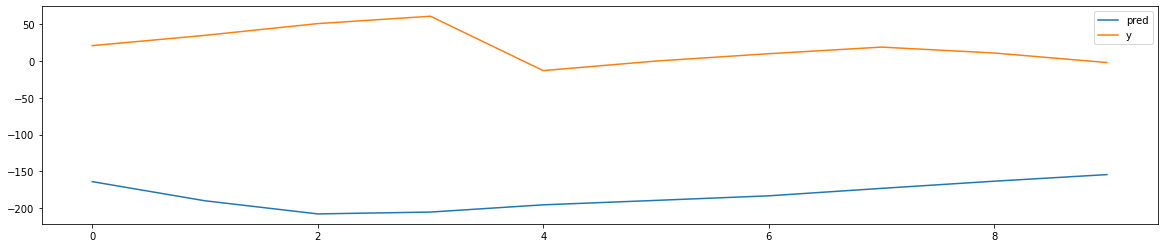

[False False False False False False False False False False]


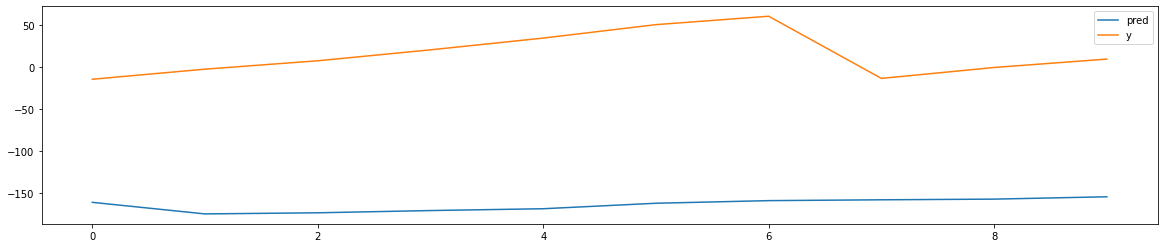

[False False False False False False False False False False]


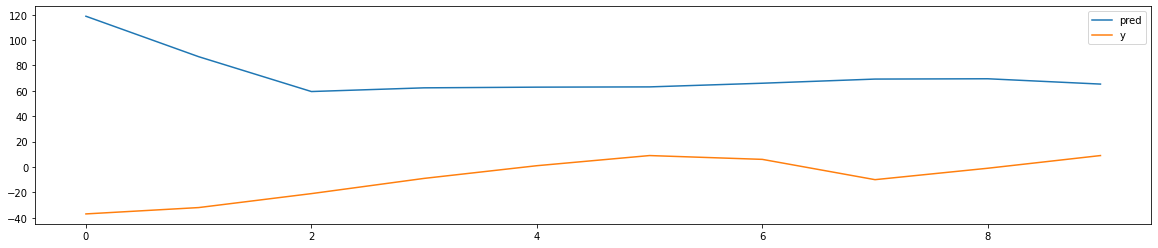

[False False False False False False False False False False]


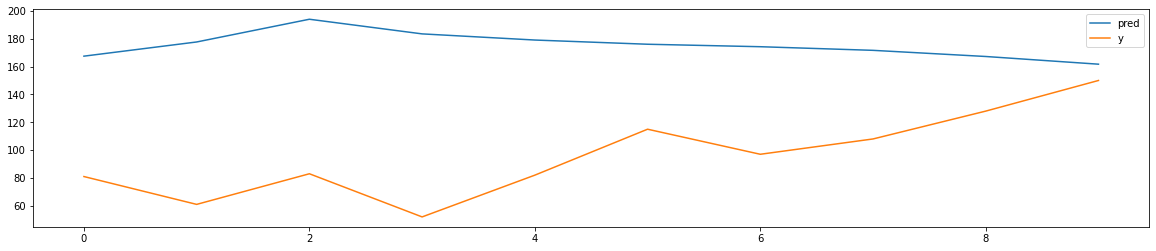

[False False False False False False False False False False]


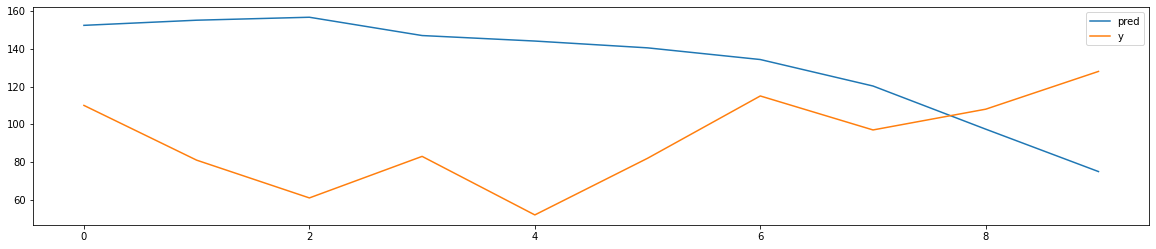

[False False False False False False False False False False]


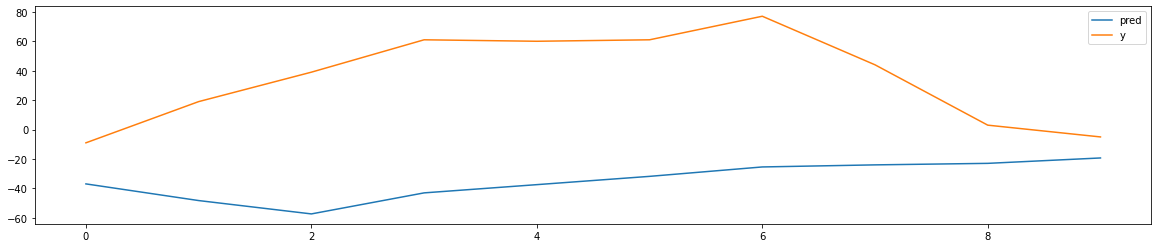

[False False False False False False False False False False]


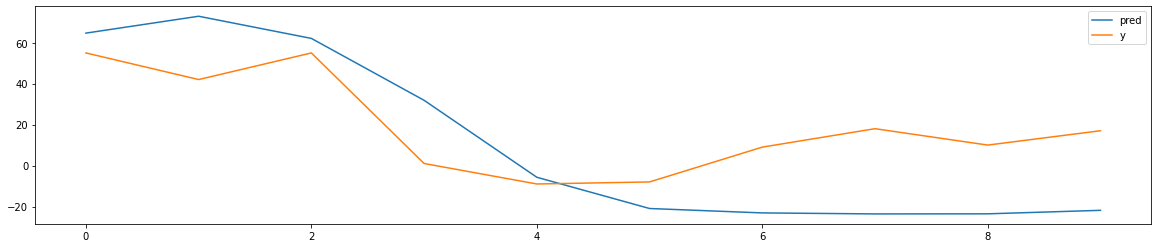

[False False False False False False False False False False]


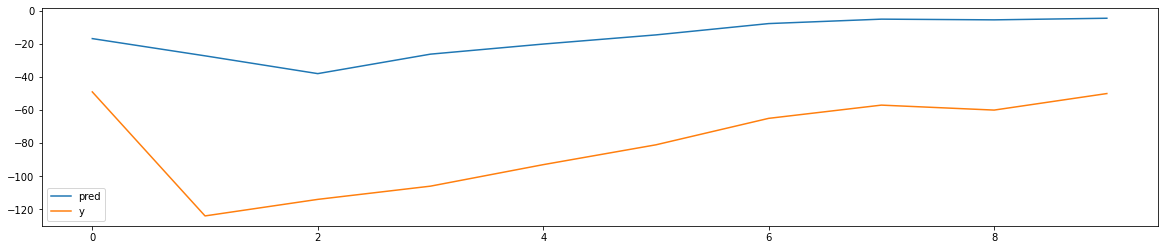

[False False False False False False False False False False]


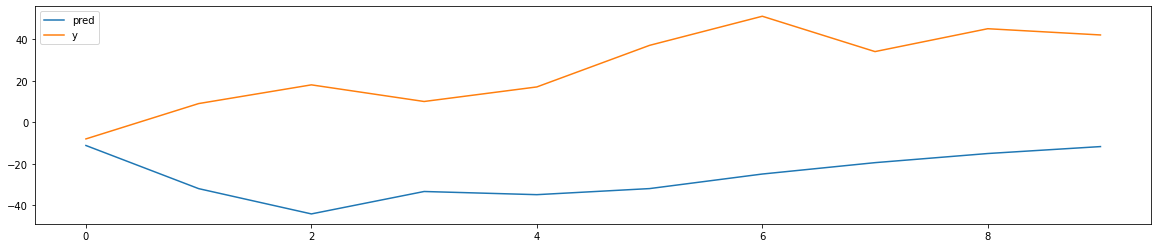

[False False False False False False False False False False]


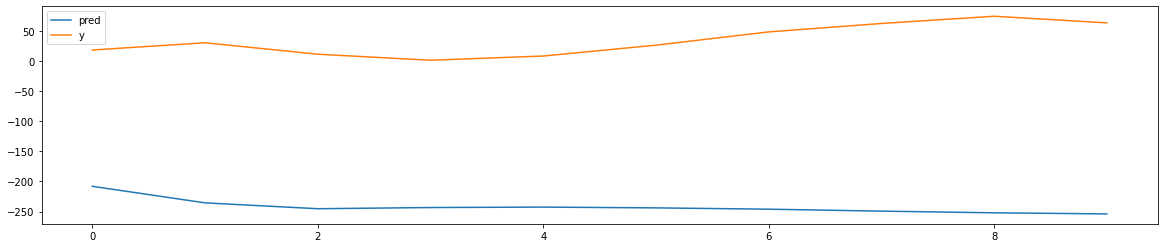

[False False False False False False False False False False]


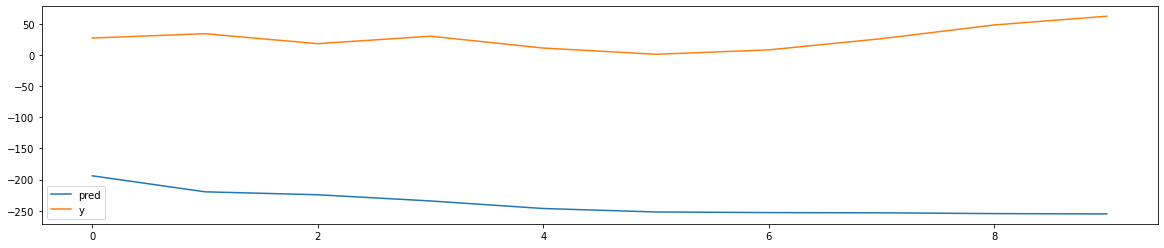

[False False False False False False False False False False]


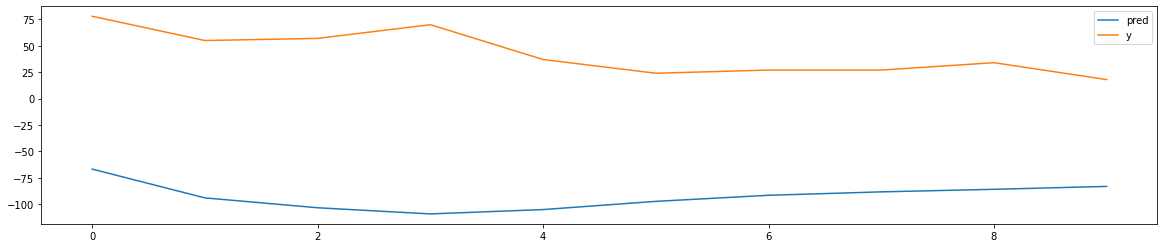

[False False False False False False False False False False]


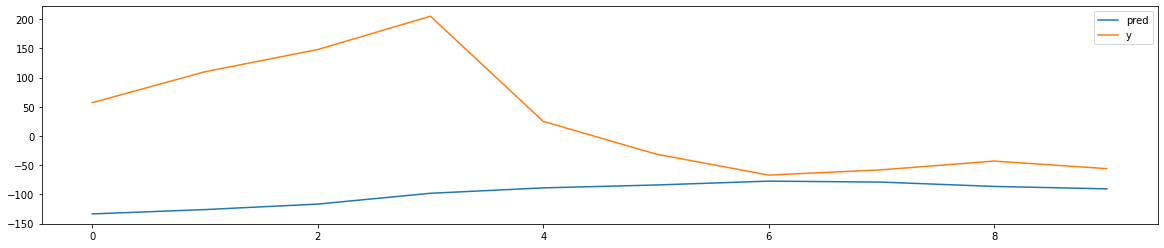

[False False False False False False False False False False]


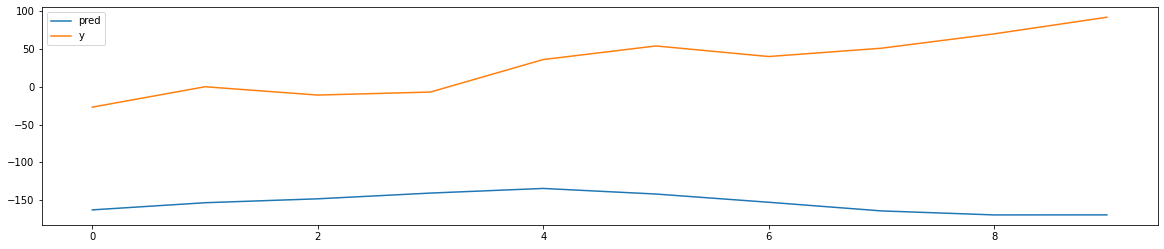

[False False False False False False False False False False]


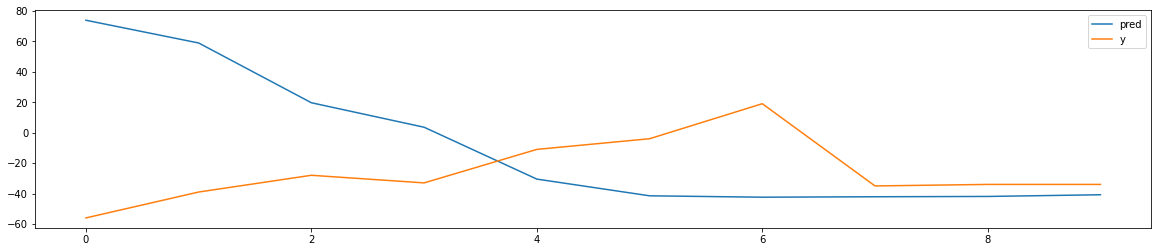

[False False False False False False  True  True  True  True]


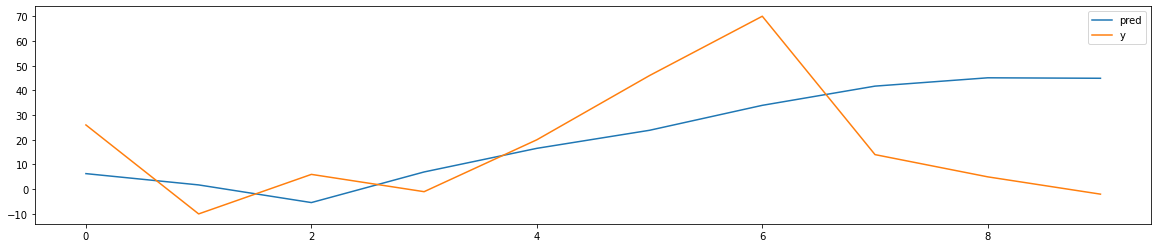

[False False False False False False False False False False]


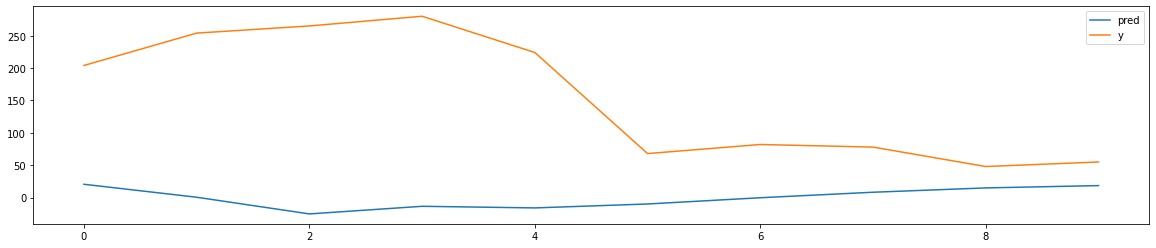

[False False False False False False False False False False]


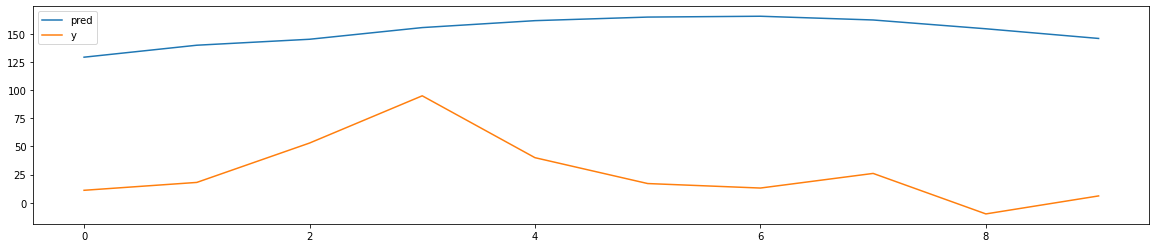

[False False False False False False False False False False]


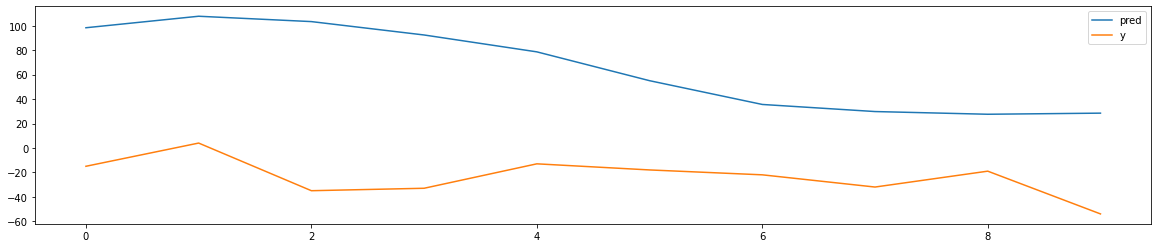

[False False False False False False False False  True  True]


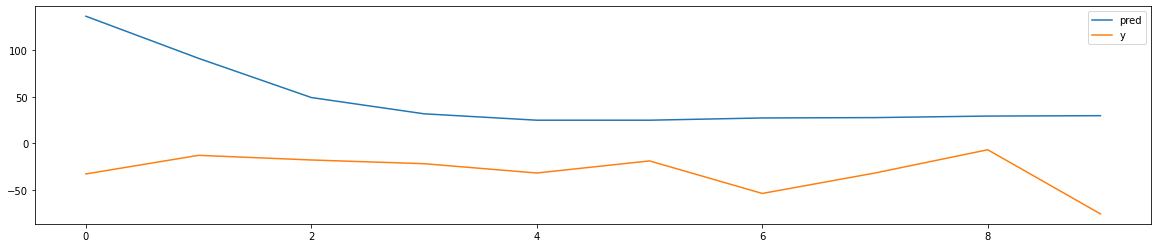

[False False False False False False False False False False]


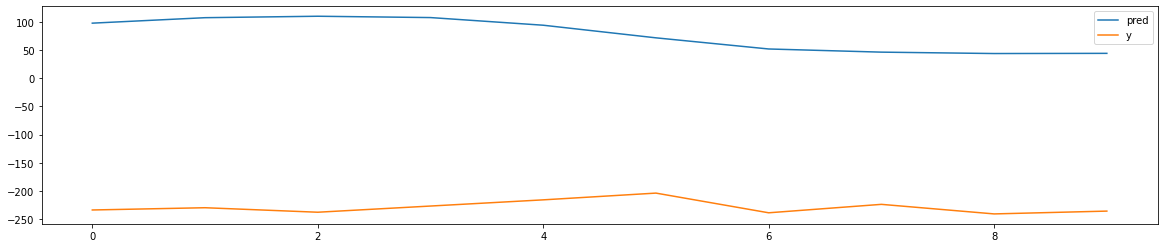

[False False False False False False False False False False]


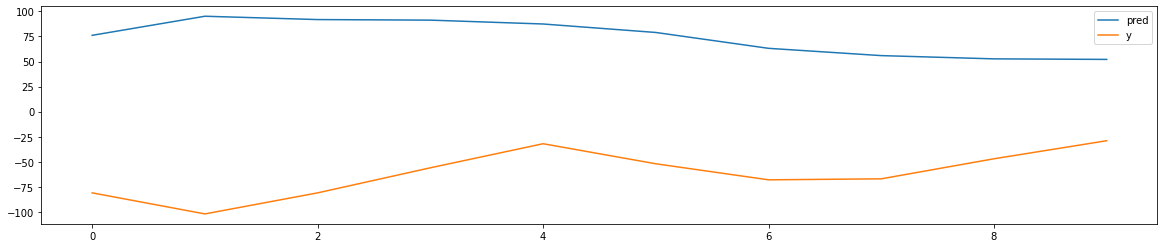

[False False False False False False False False False False]


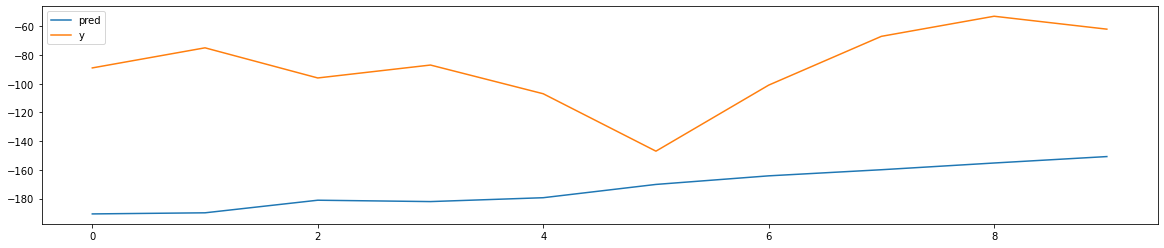

[False False False False False False False False False False]


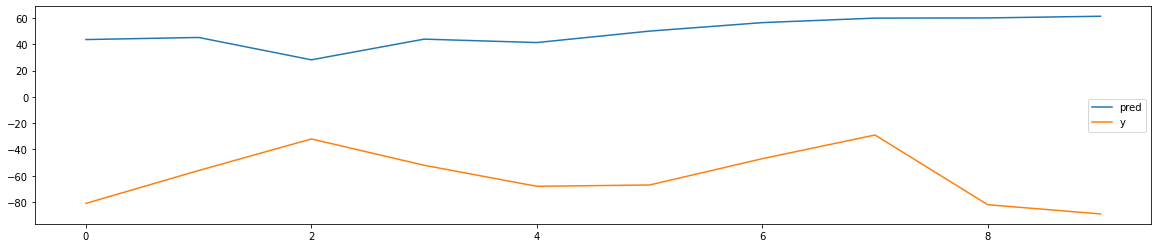

[False False False False False False False False False False]


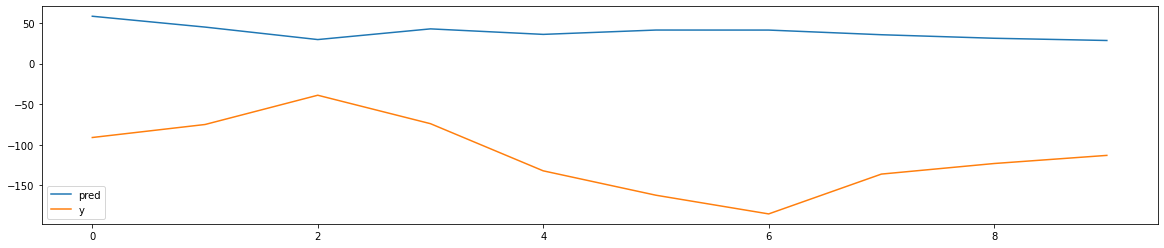

[False False False False False False False False False False]


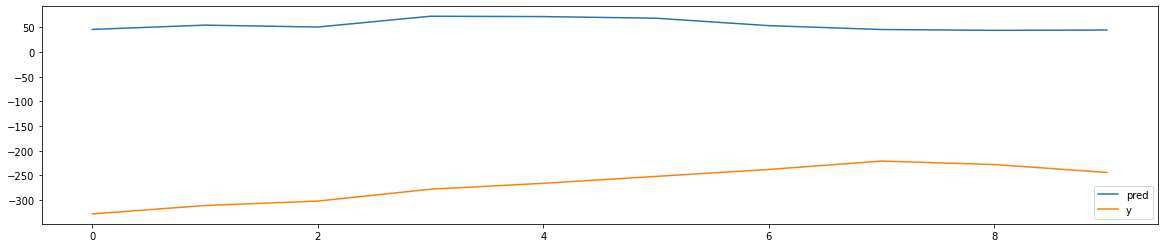

[False False False False False False False False False False]


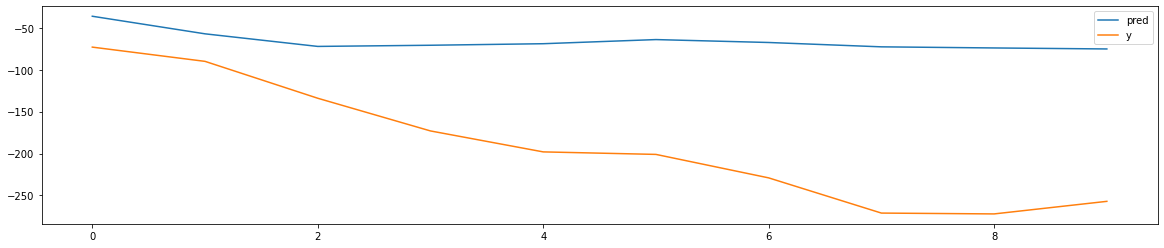

[False False False False False False False False False False]


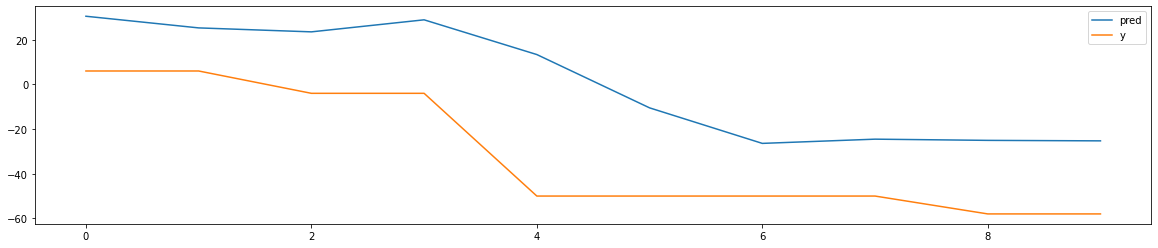

[False False False False False False False False False False]


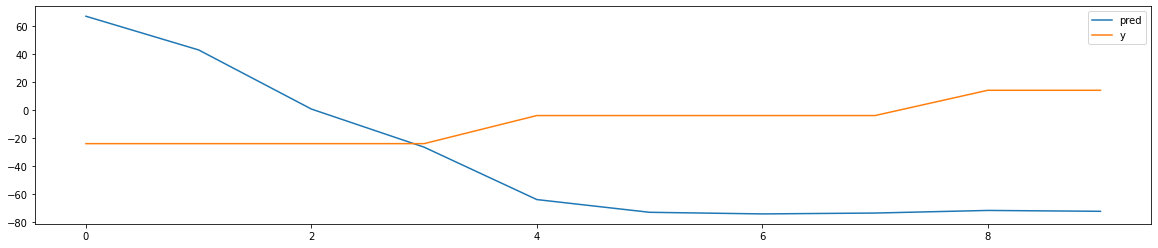

[False False False False False False False False False False]


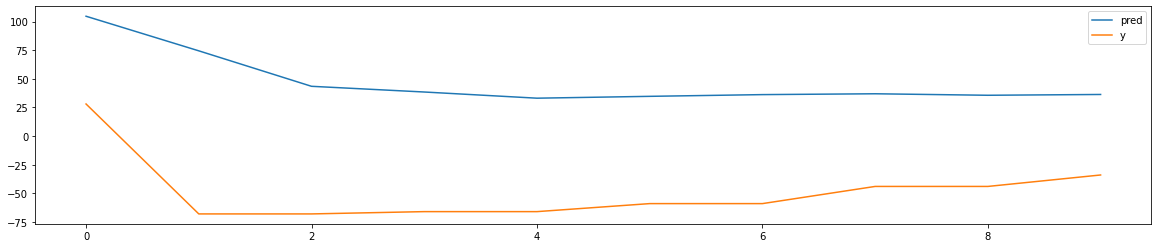

[False False False False False False False False False False]


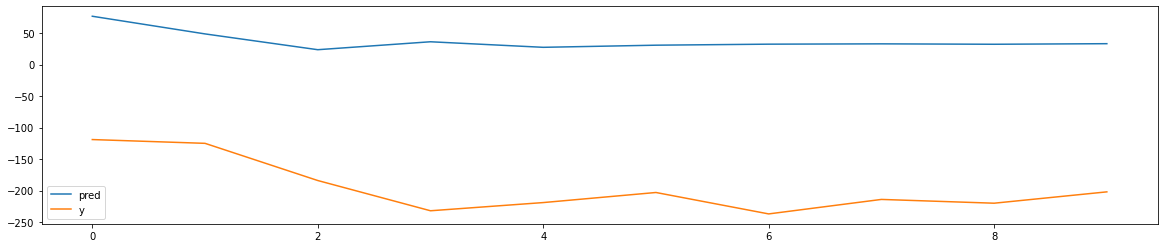

[False False False False False False False False False False]


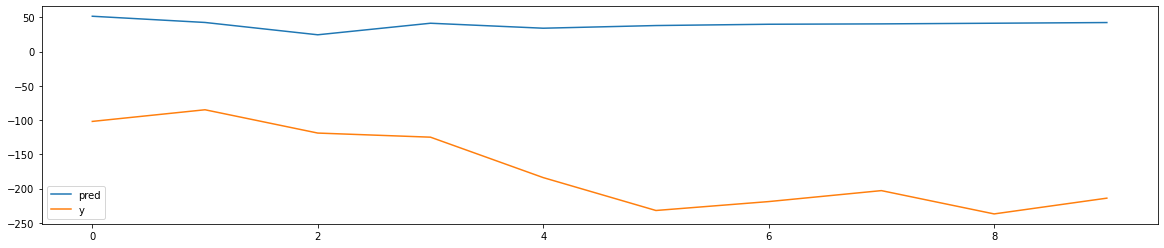

[False False False False False False False False False False]


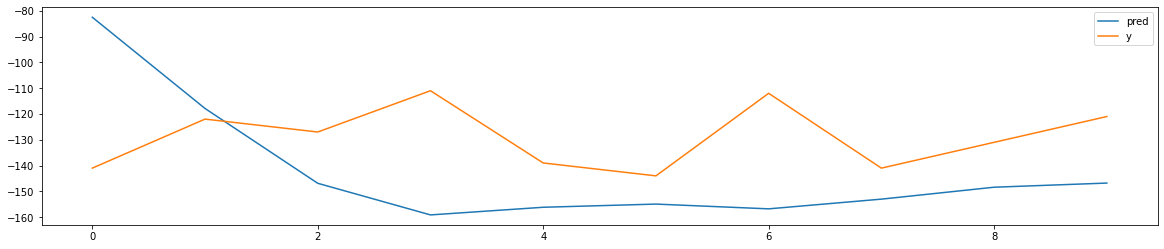

[False False False False False False False False False False]


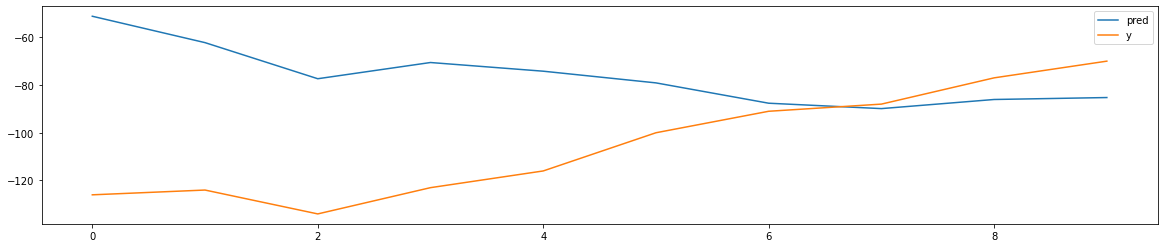

[False False False False False False False False False False]


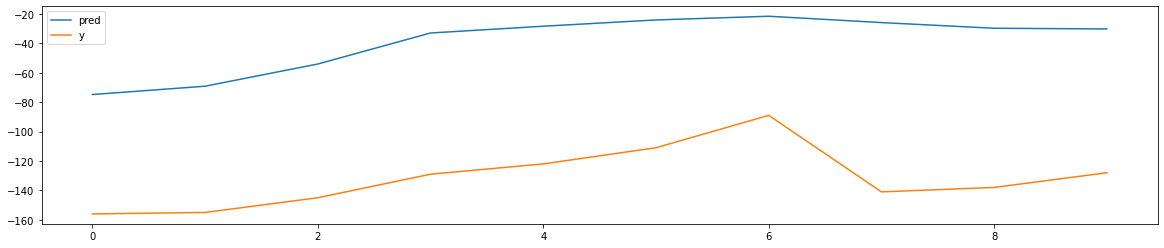

[False False False False False False False False False False]


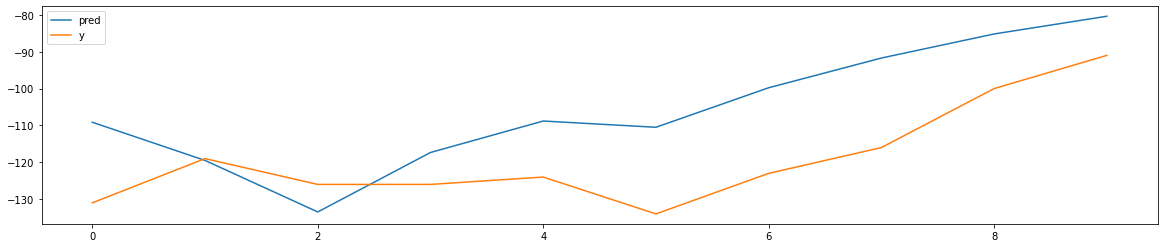

[False False False False False False False False False False]


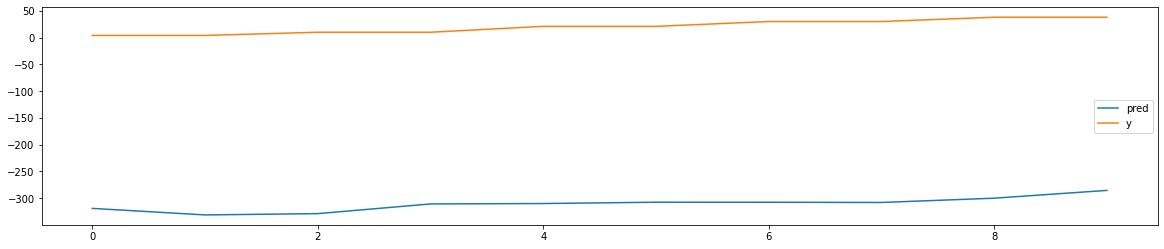

[False False False False False False False False False False]


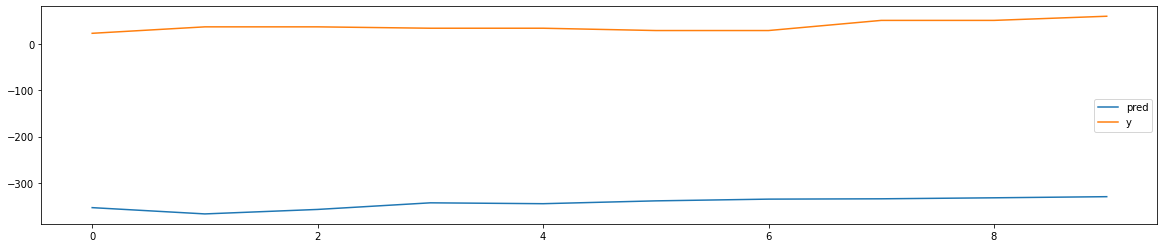

[False False False False False False False False False False]


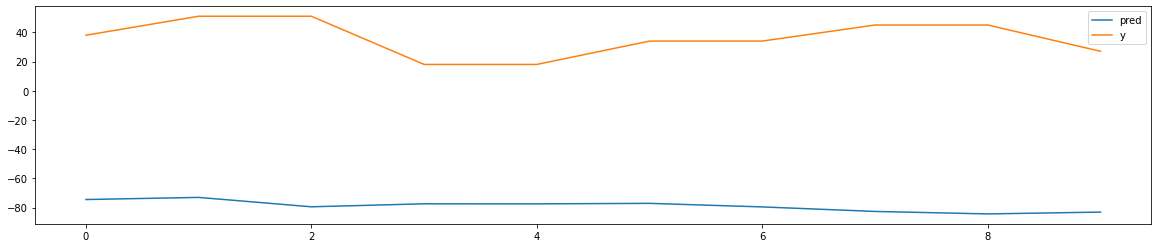

[False False False False False False False False False False]


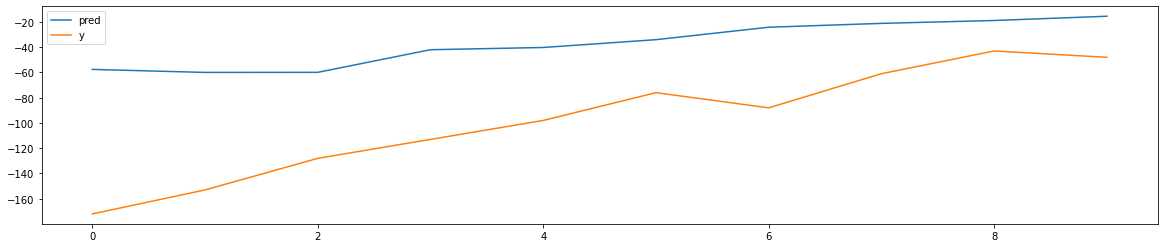

[False False False False False False False False False False]


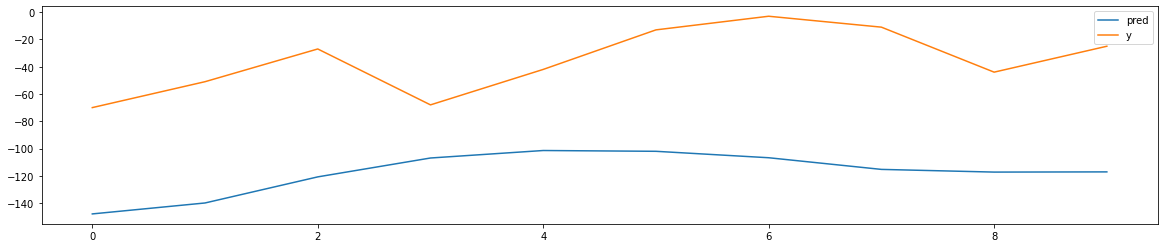

[False False False False False False False False False False]


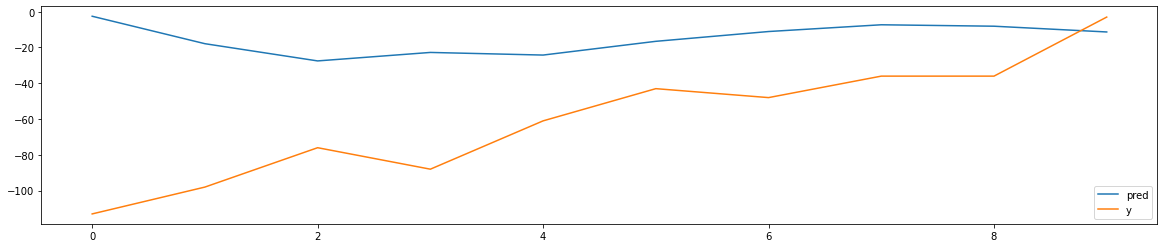

[False False False False False False False False False False]


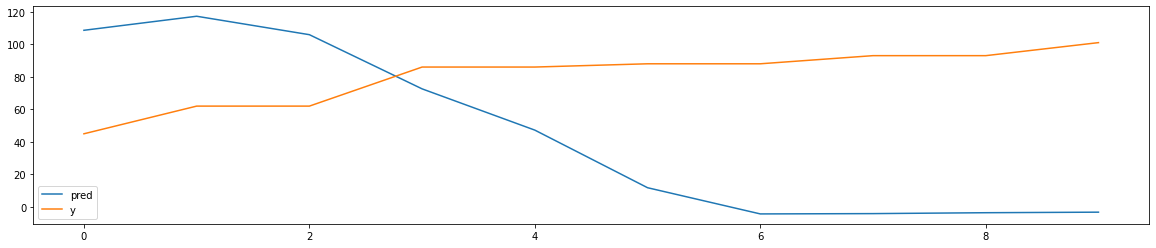

[False False False False False False False False False False]


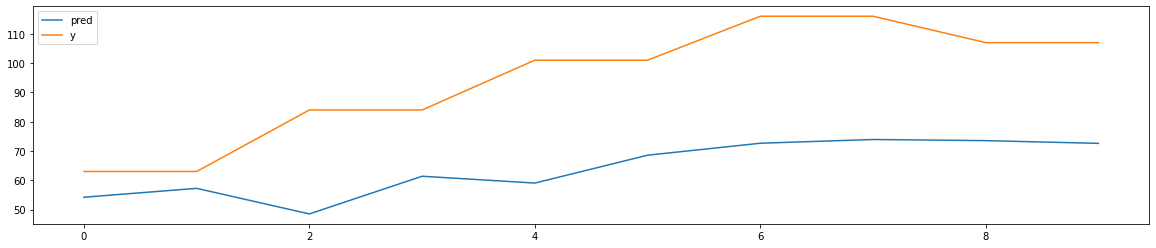

[False False False False False False False False False False]


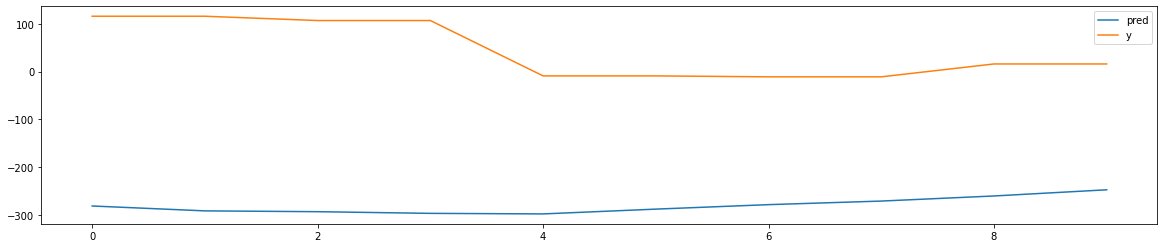

[False False False False False False False False False False]


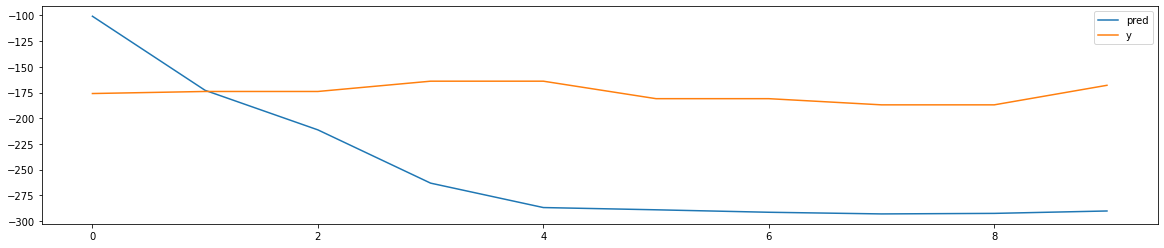

[False False False False False False False False False False]


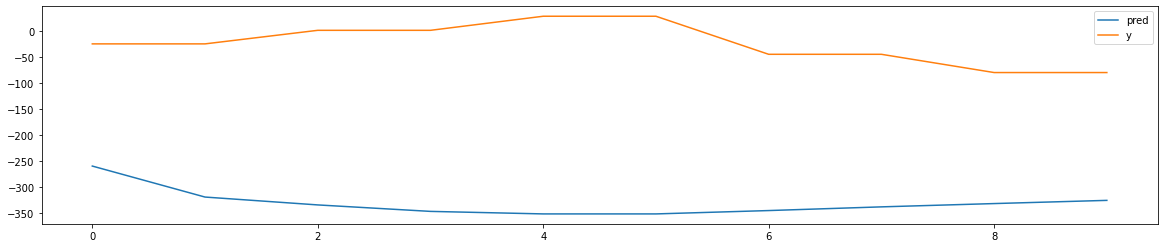

[False False False False False False False False False False]


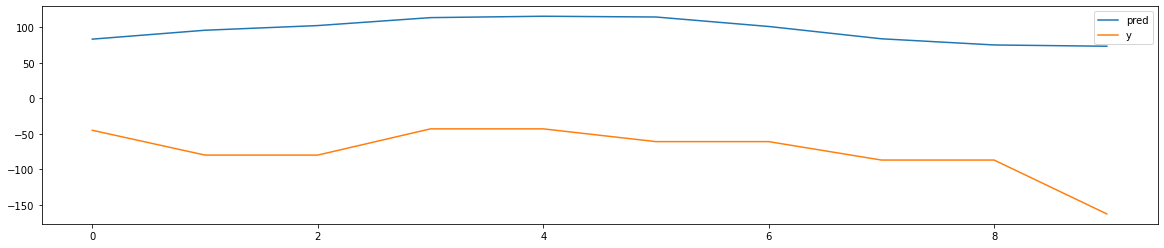

[False False False False False False False False False False]


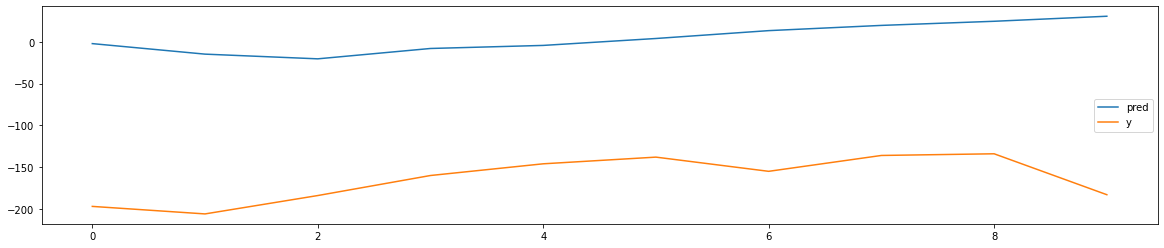

[False False False False False False False False False False]


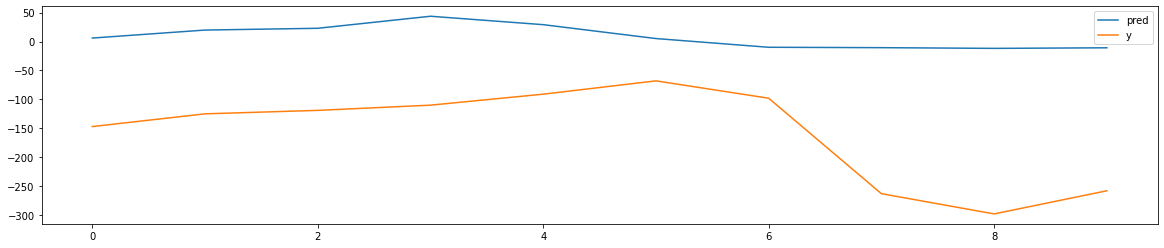

[False False False False False False False False False False]


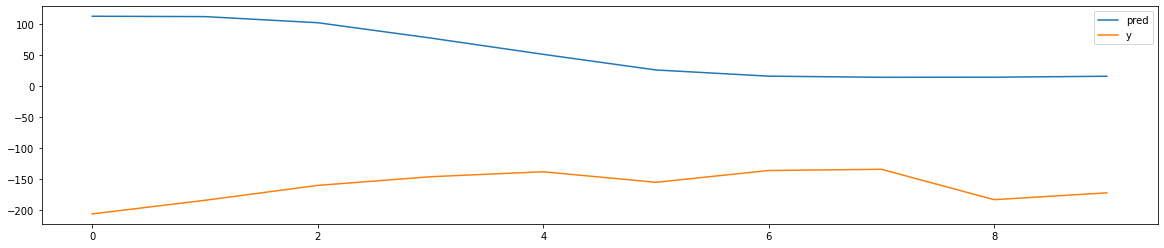

[False False False False False False False False False False]


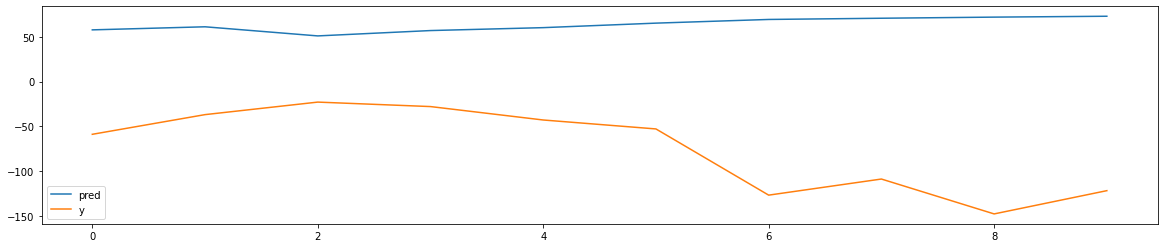

[False False False False False False False False False False]


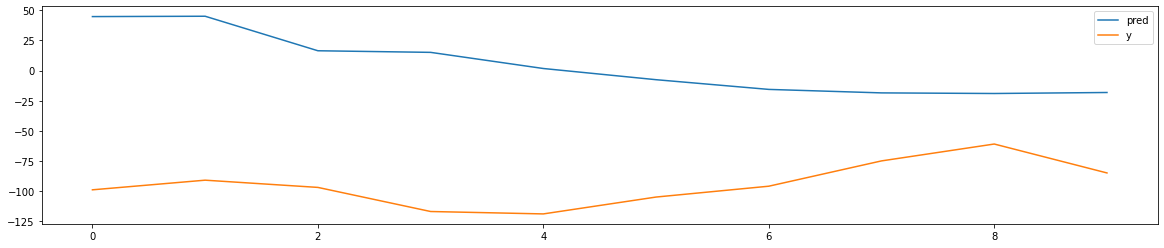

[False False False False False False False False False False]


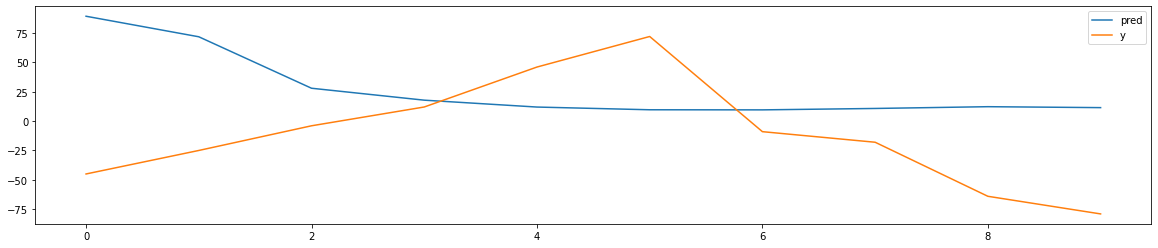

[False False False False False False False False False False]


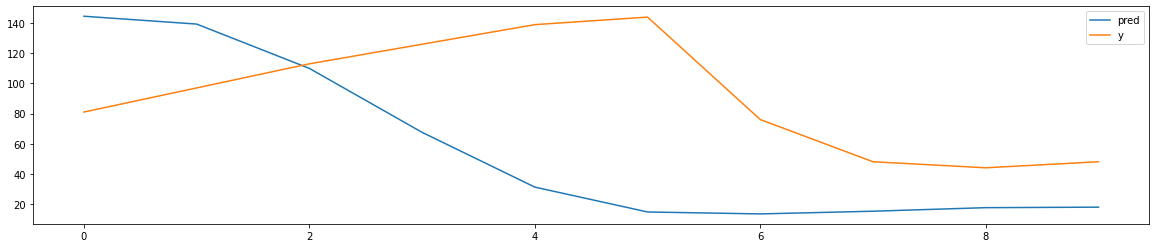

[False False False False False False False False False False]


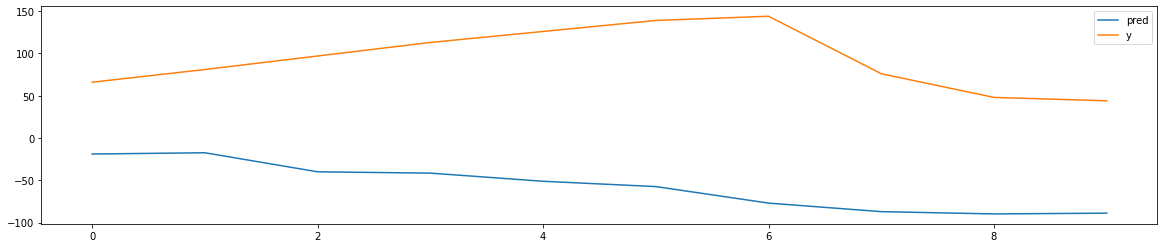

[False False False False False False False False False False]


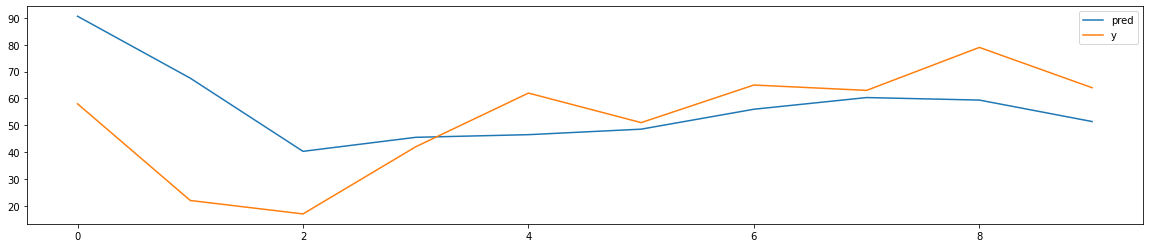

[False False False False False False False False False False]


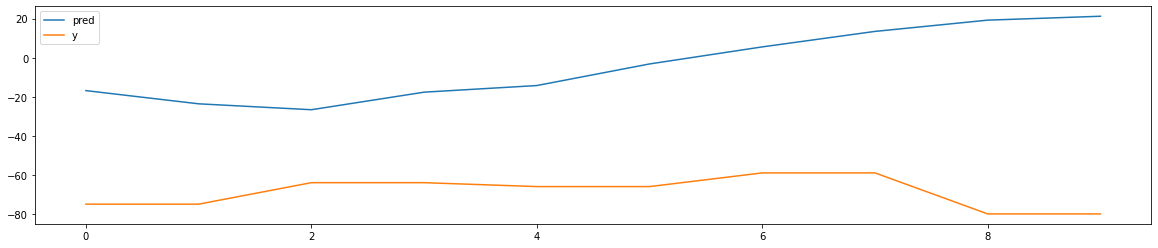

[False False False False False False False False False False]


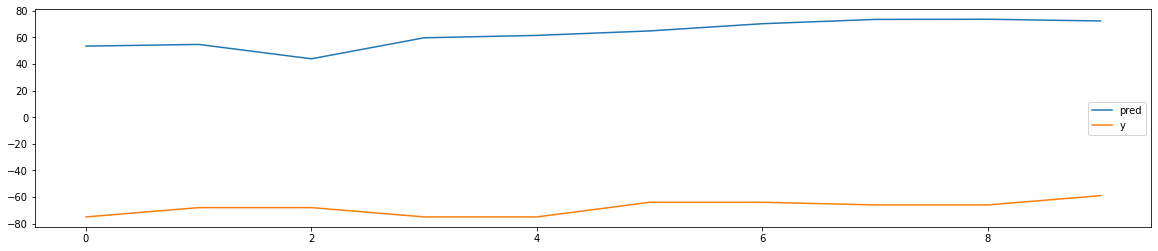

[False False False False False False False False False False]


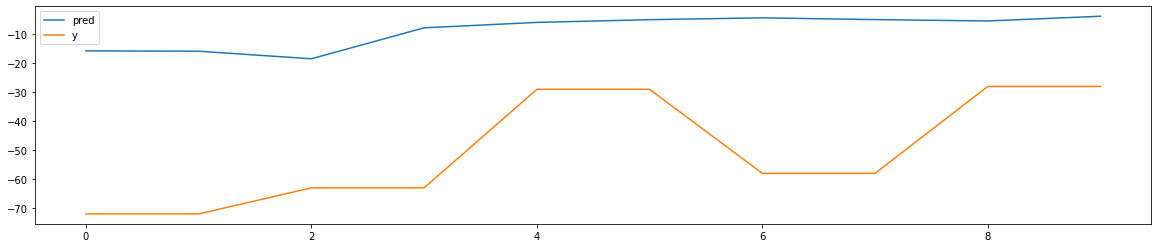

[False False False False False False False False False False]


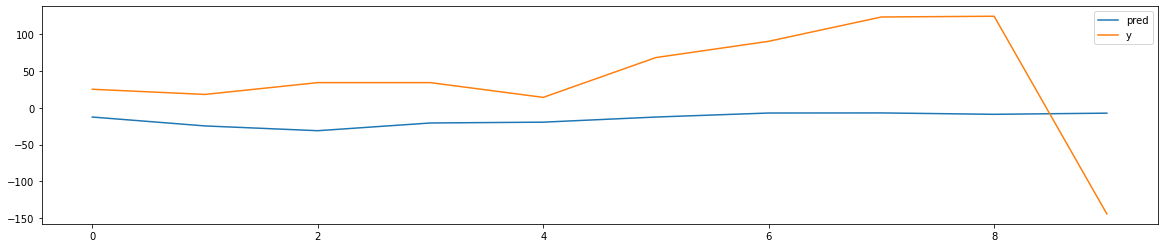

[False False False False False False False False False False]


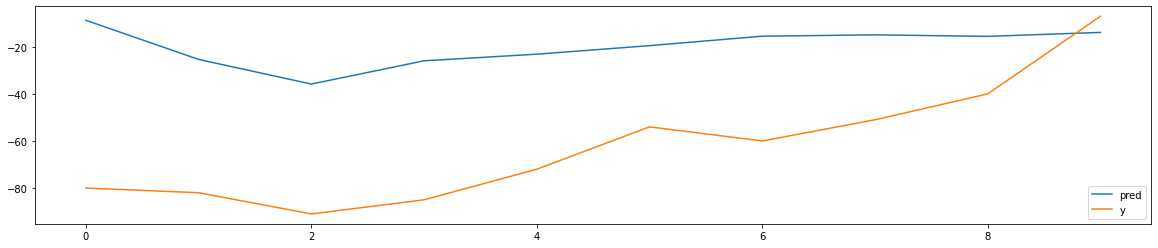

[False False False False False False False False False False]


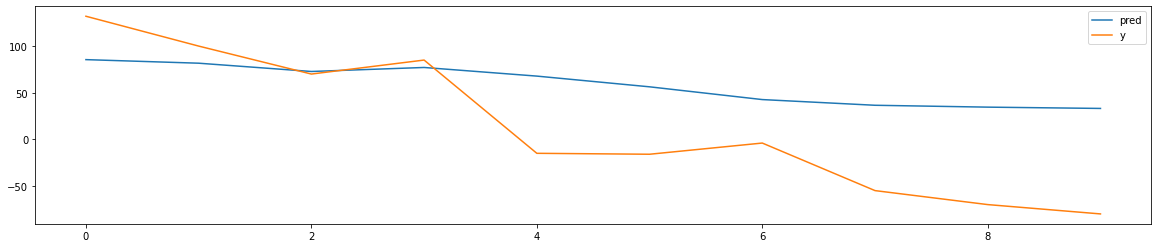

[False False False False False False False False False False]


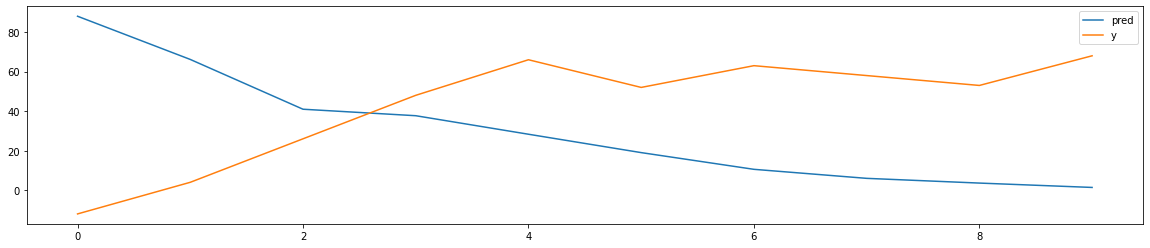

[False False False False False False False False False False]


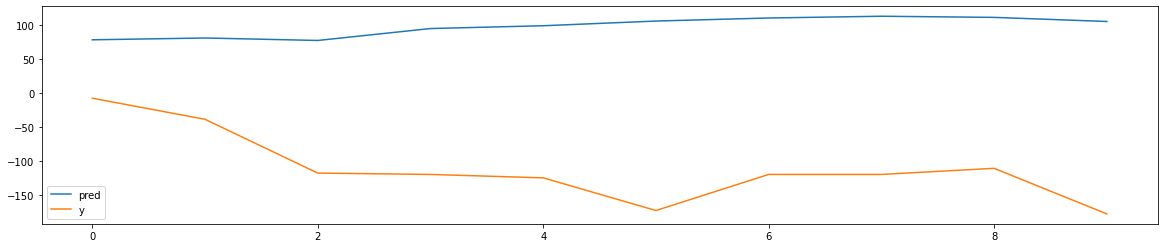

[False False False False False False False False False False]


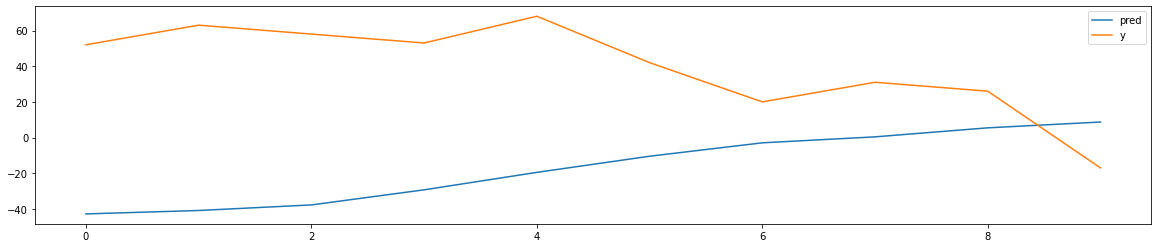

[False False False False False False False False False False]


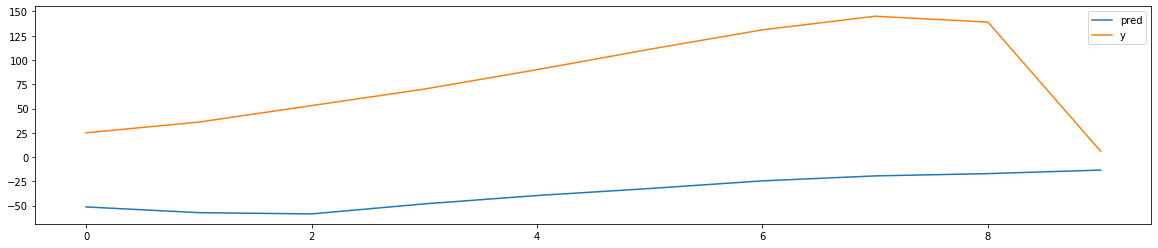

[False False False False False False False False False False]


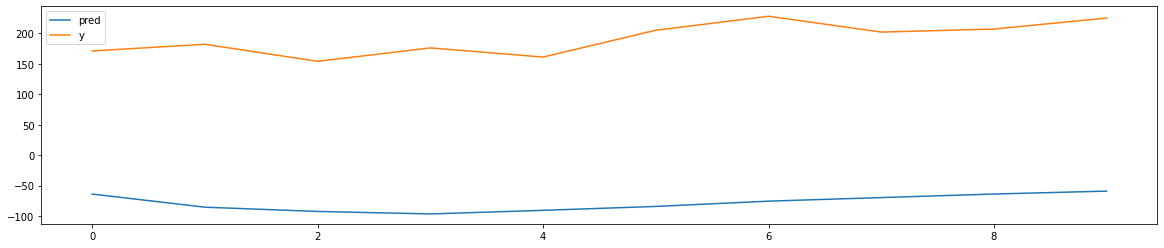

[False False False False False False False False False False]


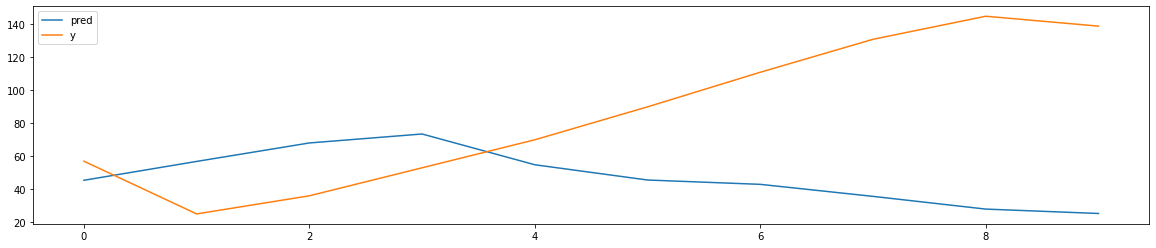

[False False False False False False False False False False]


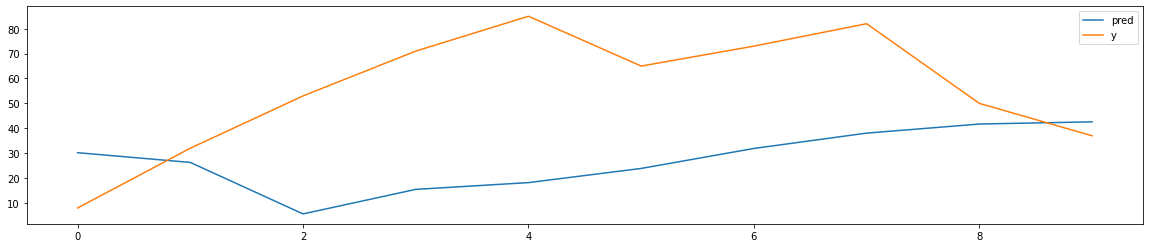

[False False False False False False False False False False]


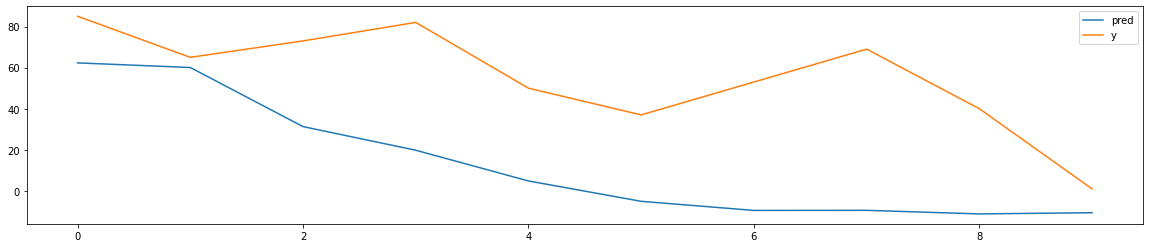

[False False False False False False False False False False]


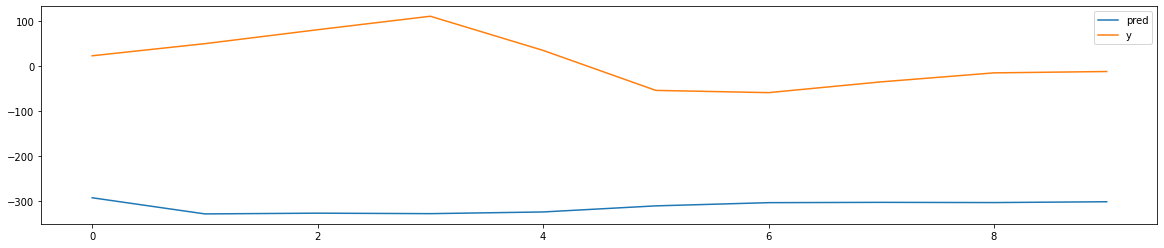

[False False False False False False False False False False]


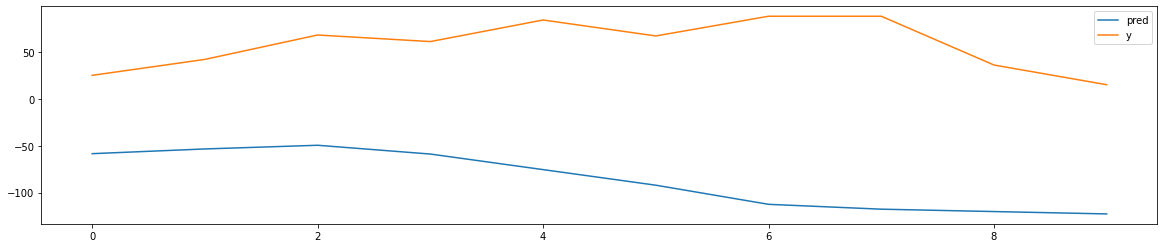

[False False False False False False False False False False]


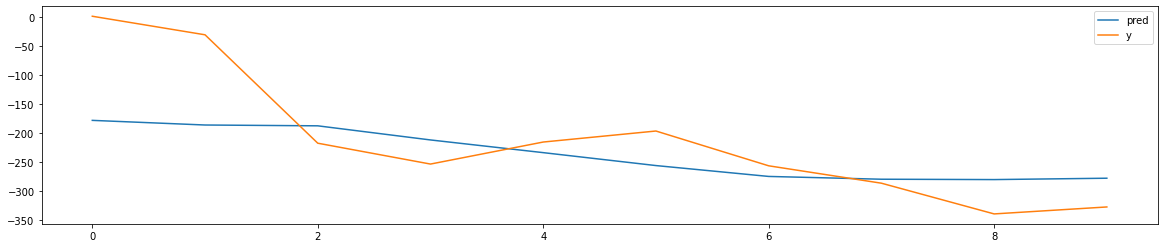

[False False False False False False False False False False]


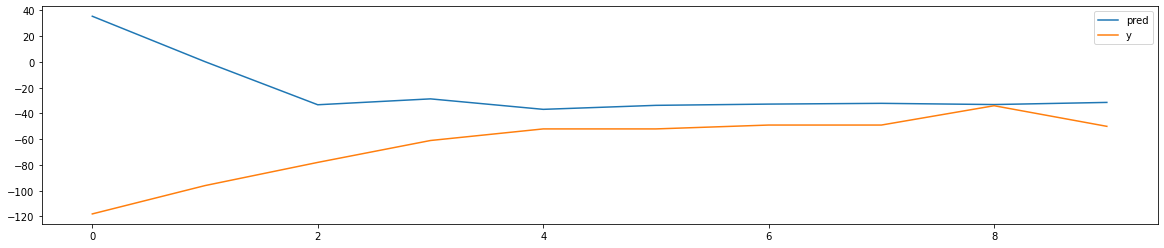

[False False False False False False False False False False]


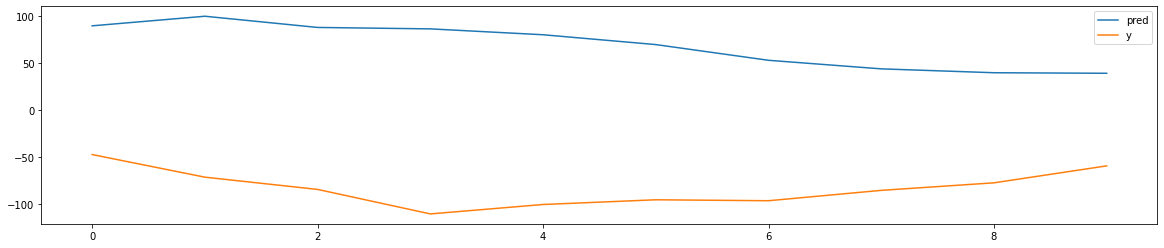

[False False False False False False False False False False]


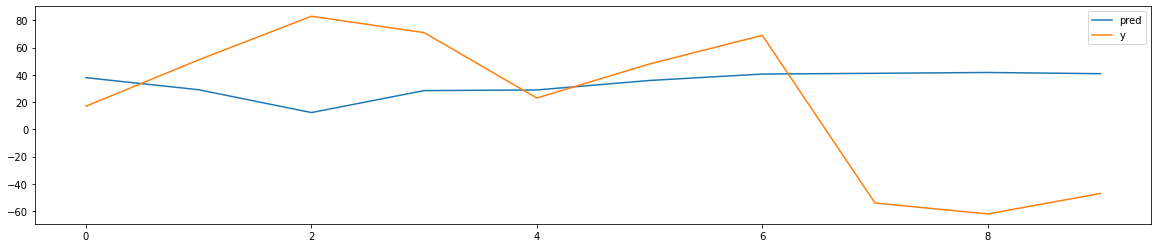

[False False False False False False False False False False]


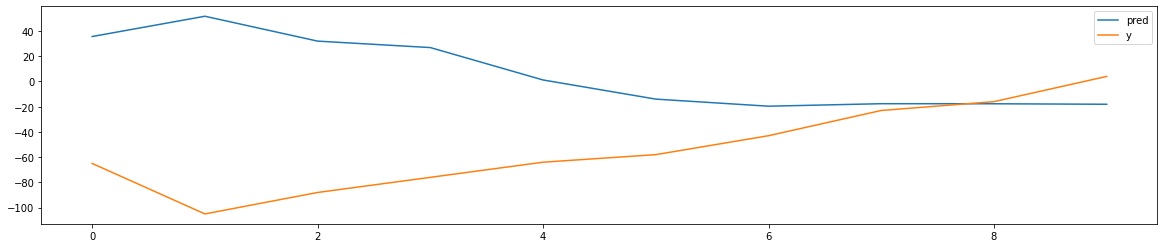

[False False False False False False False False False False]


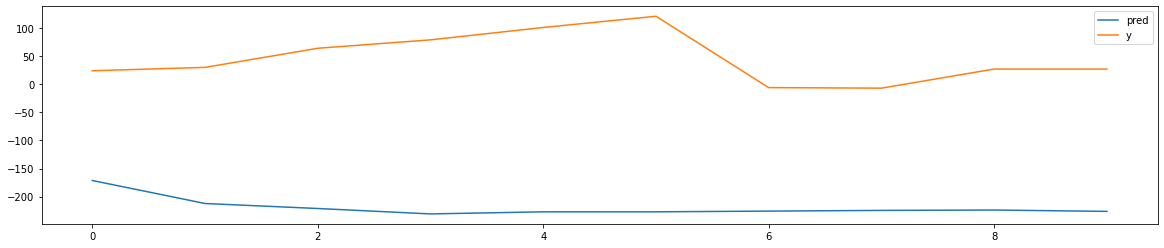

[False False False False False False False False False False]


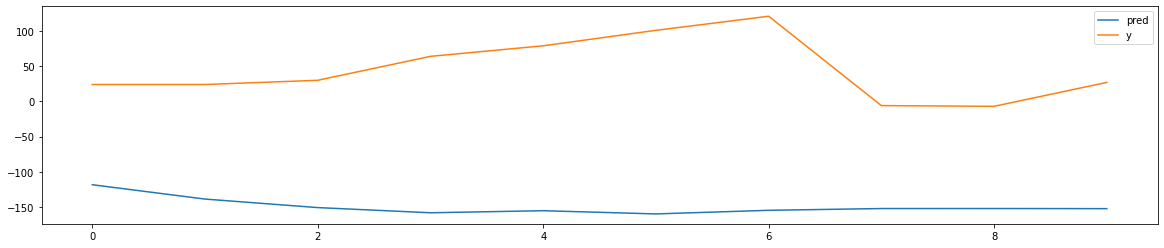

[False False False False False False False False False False]


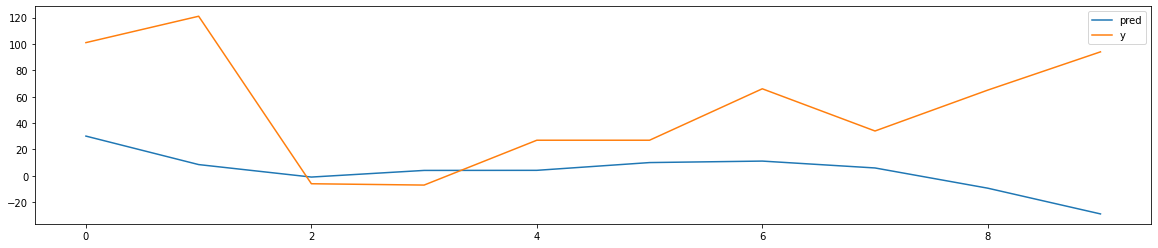

[False False False False False False False False False False]


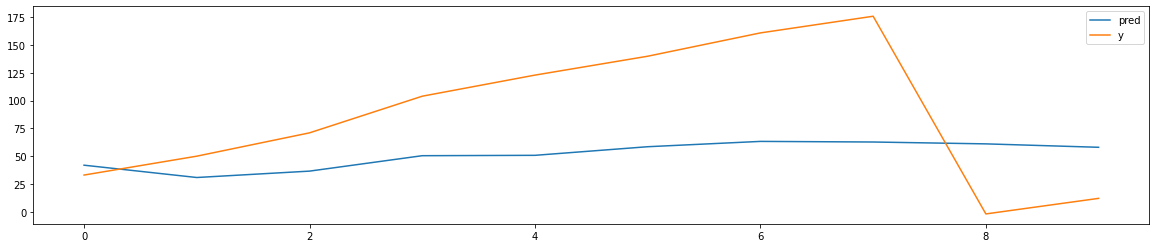

[False False False False False False False False False False]


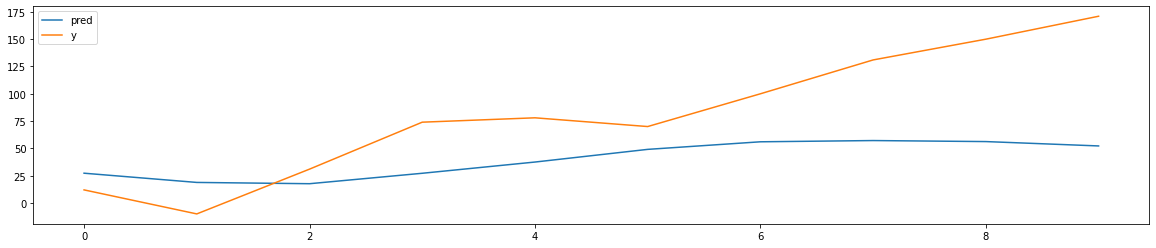

[False False False False False False False False False False]


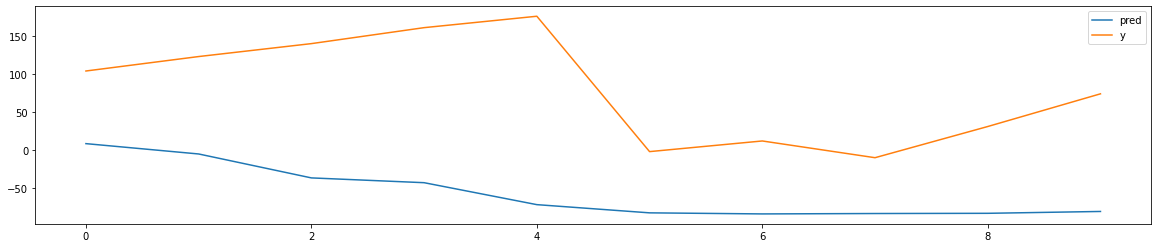

[False False False False False False False False False False]


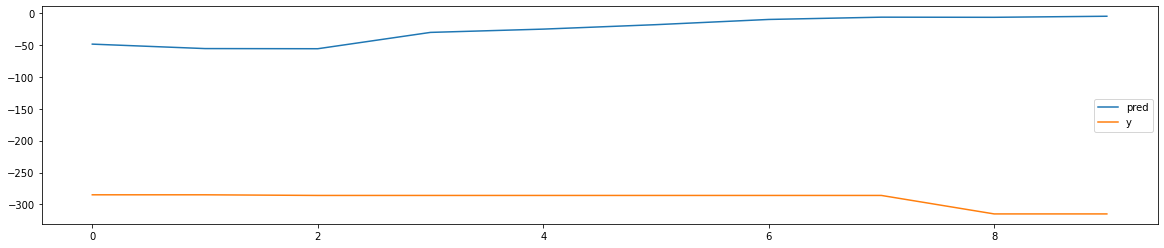

[False False False False False False False False False False]


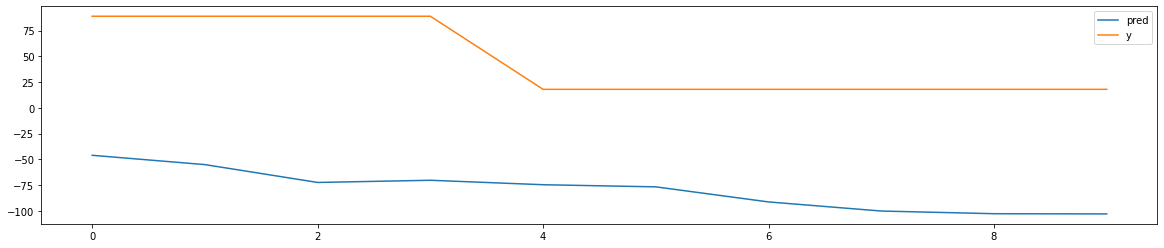

[False False False False False False False False False False]


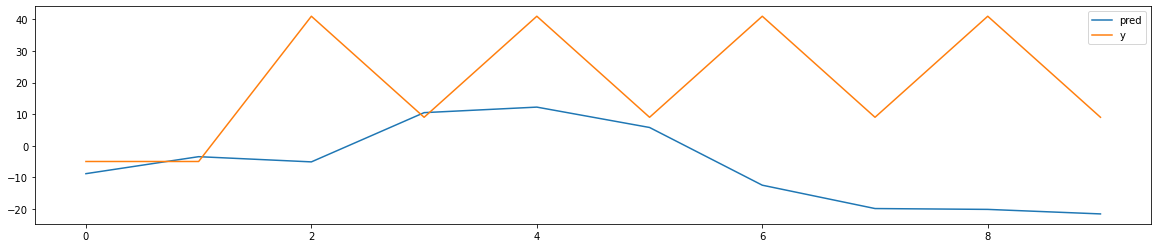

[False False False False False False False False False False]


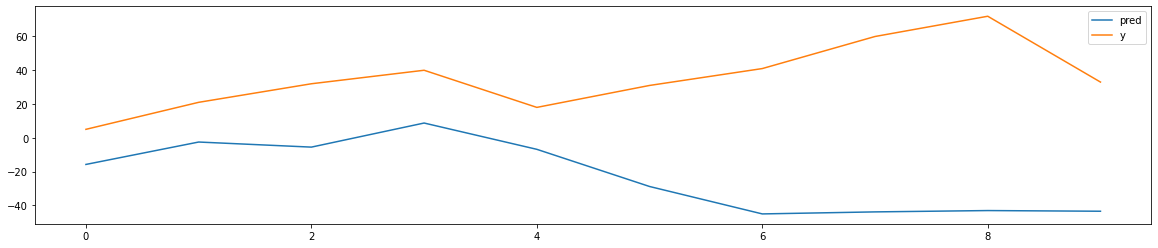

[False False False False False False False False False False]


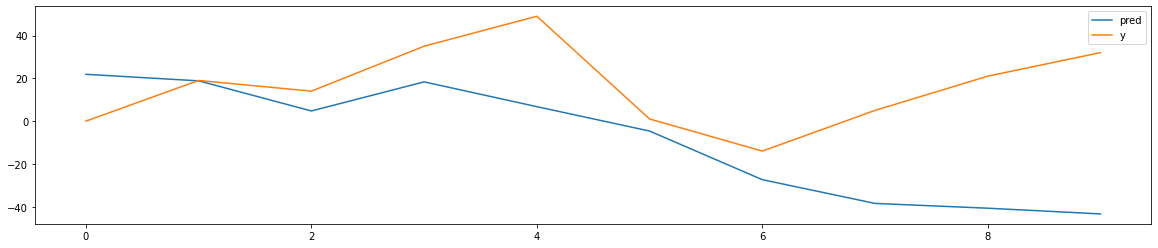

[False False False False False False False False False False]


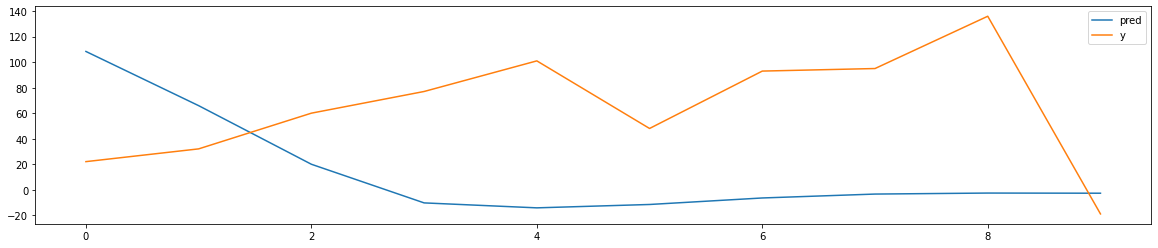

[False False False False False False False False False False]


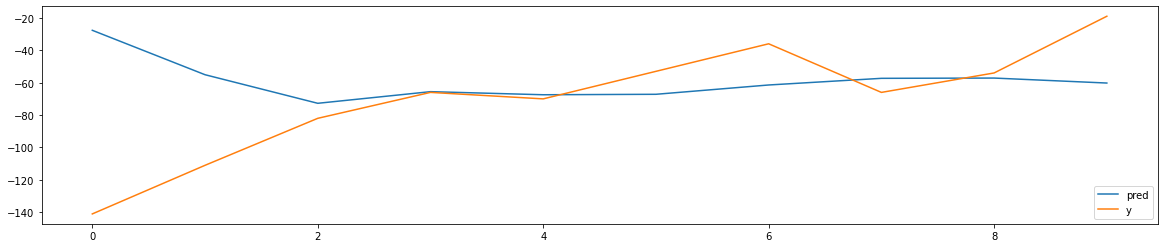

[False False False False False False False False False False]


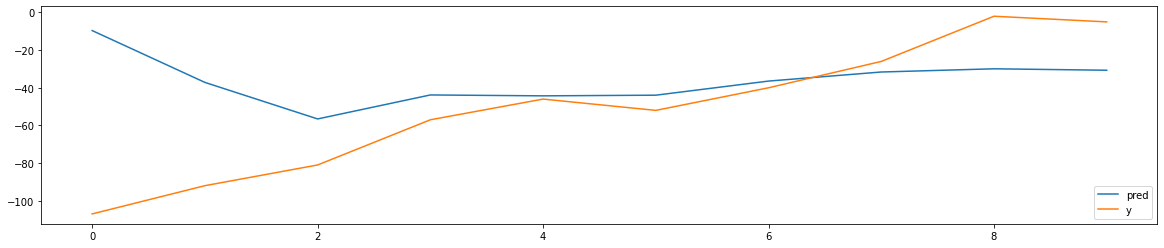

[False False False False False False False False False False]


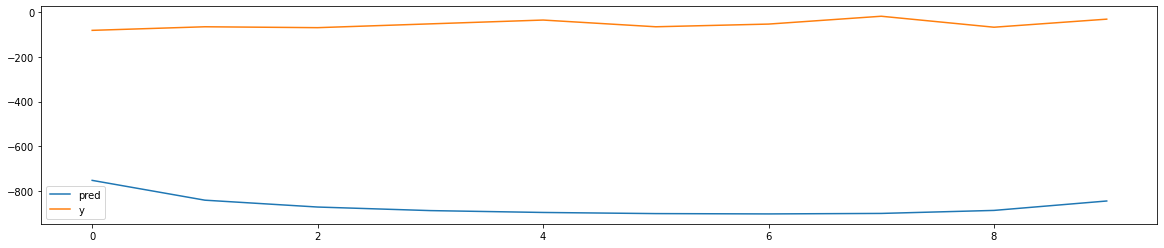

[False False False False False False False False False False]


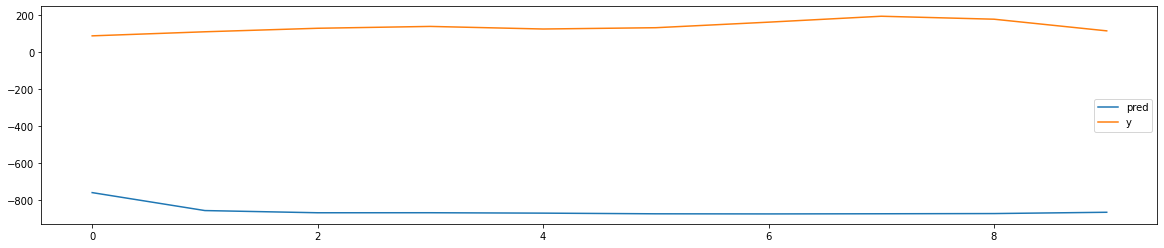

[False False False False False False False False False False]


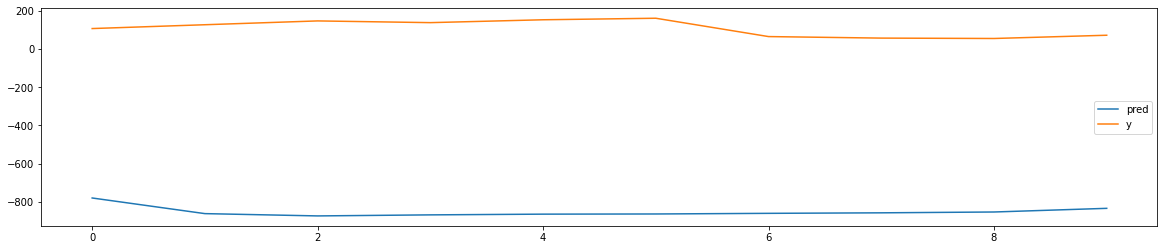

[False False False False False False False False False False]


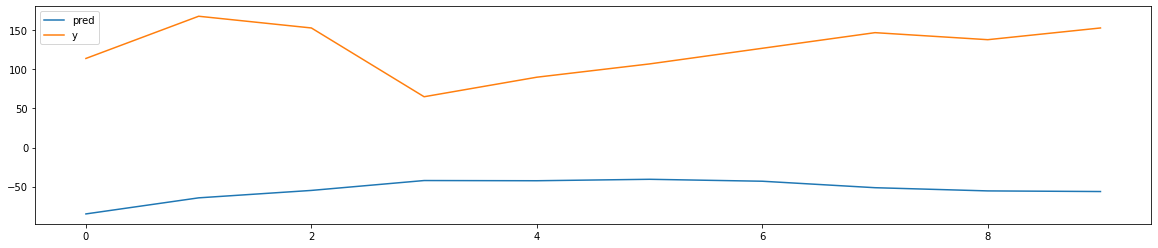

[False False False False False False False False False False]


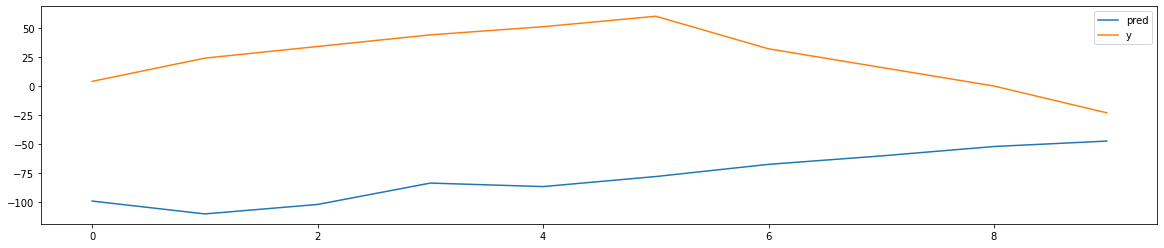

[False False False False False False False False False False]


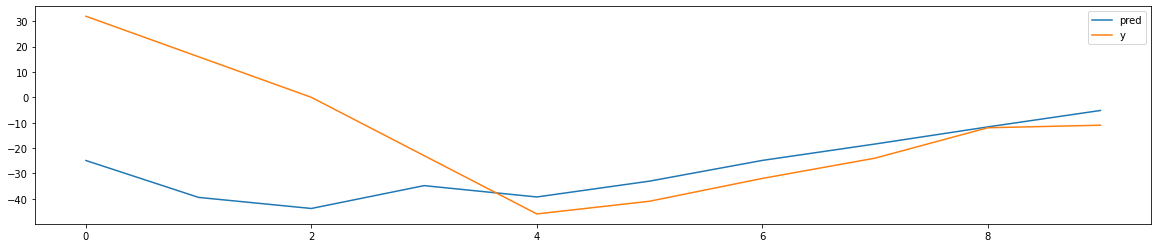

[False False False False False False False False False False]


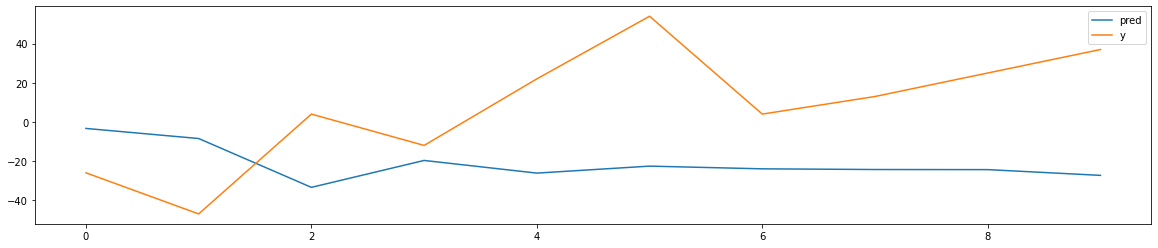

[False False False False False False False False False False]


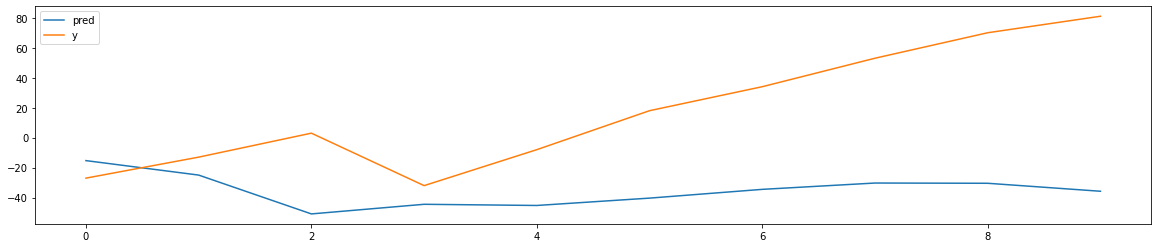

In [36]:
# np.set_printoptions(threshold=sys.maxsize)
# print(preds)
# print(len(preds))

# print(preds[0].shape)
# print(preds[1].shape)

deviance_preds = preds[0]
loc_preds = preds[1]
# for i, (d, l) in enumerate(zip(deviance_preds, loc_preds)):
#     if i < 1:
#         print(d,l)


for i, (dev_pred, loc_pred, y) in enumerate(zip(deviance_preds, loc_preds, test_dataset.unbatch().as_numpy_iterator())):
    if i < 100:
        x, y = y
        loc_label = y['location_id']
        deviance_label = y['deviance']
        
        loc_pred_maxes = [np.argmax(x) for x in loc_pred]
        loc_label_maxes = [np.argmax(x) for x in loc_label]
        
        print (loc_pred_maxes == np.argmax(loc_label_maxes))
        x = list(range(out_length))

        plt.rcParams["figure.figsize"] = [20, 4]
        plt.plot(x, dev_pred, label="pred")
        plt.plot(x, deviance_label, label="y")
        plt.legend()
        plt.show()

allDone()